In [2]:
import pandas as pd
import os
import numpy as np
import pytz
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import pytz as tz
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.signal import butter, filtfilt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [3]:
RESPECK_FILE = '../data/bishkek_csr/03_train_ready/respeck/08-05-2025_respeck.csv'
PSG_FILE = '../data/bishkek_csr/03_train_ready/nasal_files/08-05-2025_nasal.csv'
LABELS_FILE = '../data/bishkek_csr/03_train_ready/event_exports/08-05-2025_event_export.csv'
OUTPUT_FILE = './08-05-2025_respeck_features.csv'

# --- Load Data ---
print("Loading data...")

respeck_df = pd.read_csv(RESPECK_FILE)
respeck_df['timestamp'] = pd.to_datetime(respeck_df['alignedTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
respeck_df['timestamp'] = respeck_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
# respeck_df.set_index('timestamp', inplace=True, drop=False)
print(respeck_df['timestamp'])


psg_df = pd.read_csv(PSG_FILE)
psg_df['timestamp'] = pd.to_datetime(psg_df['UnixTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
psg_df['timestamp'] = psg_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
print(psg_df['timestamp'])
# psg_df.set_index('timestamp', inplace=True)

labels_df = pd.read_csv(LABELS_FILE)
labels_df['timestamp'] = pd.to_datetime(labels_df['UnixTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
labels_df['timestamp'] = labels_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
# labels_df.set_index('timestamp', inplace=True)

Loading data...
0        2025-05-08 00:00:58.562000+06:00
1        2025-05-08 00:00:58.642000+06:00
2        2025-05-08 00:00:58.722000+06:00
3        2025-05-08 00:00:58.802000+06:00
4        2025-05-08 00:00:58.882000+06:00
                       ...               
263419   2025-05-08 05:51:48.255000+06:00
263420   2025-05-08 05:51:48.335000+06:00
263421   2025-05-08 05:51:48.415000+06:00
263422   2025-05-08 05:51:48.495000+06:00
263423   2025-05-08 05:51:48.575000+06:00
Name: timestamp, Length: 263424, dtype: datetime64[ns, Asia/Bishkek]
0                2025-05-07 23:58:33+06:00
1         2025-05-07 23:58:33.010000+06:00
2         2025-05-07 23:58:33.020000+06:00
3         2025-05-07 23:58:33.030000+06:00
4         2025-05-07 23:58:33.040000+06:00
                        ...               
2027795   2025-05-08 05:36:30.950000+06:00
2027796   2025-05-08 05:36:30.960000+06:00
2027797   2025-05-08 05:36:30.970000+06:00
2027798   2025-05-08 05:36:30.980000+06:00
2027799   2025-05-08 05

In [77]:
# forward and back fill respeck data before extraction

start_time_respeck = respeck_df['timestamp'].min()
end_time_respeck = respeck_df['timestamp'].max()

start_time_psg = psg_df['timestamp'].min()
end_time_psg = psg_df['timestamp'].max()

overlap_start = max(start_time_respeck, start_time_psg)
overlap_end = min(end_time_respeck, end_time_psg)


print(overlap_start)
print(overlap_end)

respeck_df = respeck_df[(respeck_df['timestamp'] >= overlap_start) & (respeck_df['timestamp'] <= overlap_end)]
psg_df = psg_df[(psg_df['timestamp'] >= overlap_start) & (psg_df['timestamp'] <= overlap_end)]

# Dynamically calculate the sampling rate from the timestamps
time_diffs_ms = respeck_df['alignedTimestamp'].diff().median()
if pd.isna(time_diffs_ms) or time_diffs_ms == 0:

    fs = 1000.0 / time_diffs_ms  # Sampling frequency in Hz
    print(f"    - Calculated sampling rate: {fs:.2f} Hz")

    # Define filter parameters
    lowcut = 0.1   # Lower cutoff frequency in Hz
    highcut = 1.5  # Upper cutoff frequency in Hz
    order = 2      # Filter order (2 is a good choice to avoid distortion)

    try:
        # Design the Butterworth bandpass filter
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        
        respeck_df['original_breathingSignal'] = respeck_df['breathingSignal']

    # 2. Apply the filter and OVERWRITE the 'breathingSignal' column with the clean data
        respeck_df['breathingSignal'] = filtfilt(b, a, respeck_df['breathingSignal'])

        # # Apply the filter and store it in a NEW column
        # # We keep the original 'breathingSignal' for reference
        # respeck_df['filteredBreathingSignal'] = filtfilt(b, a, respeck_df['breathingSignal'])
    except ValueError as e:
        print(f"  - WARNING: Skipping session. Filter could not be applied. Error: {e}")


2025-05-08 00:00:58.570000+06:00
2025-05-08 05:36:30.925000+06:00


In [5]:
# Jack's Util file

def nans(dims):
    a = np.empty(dims)
    a[:] = np.nan
    return a

''' Find the RMS value of an input signal in array form. '''
def rms(signal):
    return np.sqrt(np.mean(signal**2))

def rmsHamming(signal):
    squares = signal**2
    weights = np.hamming(len(signal))
    weightedSum = 0.0
    weightsSum = 0.0

    for i in range(len(signal)):
        weightedSum += squares[i] * weights[i]
        weightsSum += weights[i]

    return np.sqrt(weightedSum / weightsSum)

''' Find islands of defined values in a signal that may contain NaNs. '''
def findIslandLimits(signal, minIslandLength=0, minIslandGap=0):

    islands = []

    start = None
    end = None
    foundIsland = False

    for i in range(len(signal)):
        if not signal[i]:
            if start == None:
                start = i
            else:
                end = i + 1
                if i == len(signal) - 1:
                    foundIsland = True
        else:
            if start != None:
                if end != None:
                    foundIsland = True
                else:
                    start = None

        if foundIsland:
            if (minIslandGap > 0) and (len(islands) > 0):
                prevIslandStart = islands[-1][0]
                prevIslandEnd = islands[-1][1]
                islandGap = start - prevIslandEnd - 1
                if islandGap < minIslandGap:
                    # merge the new island with the previous one
                    islands[-1] = ((prevIslandStart, end))
                else:
                    islands.append((start, end))
            else:    
                islands.append((start, end))

            start = None
            end = None
            foundIsland = False
            
    # now return only the islands that are long enough
    longIslands = []
    for island in islands:
        if (island[1] - island[0]) >= minIslandLength:
            longIslands.append(island)

    return longIslands

def calculateThresholdLevels(signal, rmsBackwardLength, rmsForwardLength, rmsMultiplier, symmetrical):
    result = nans((len(signal), 2))
    
    if not symmetrical:
        
        #fill sum of squares buffers
        posValues = []
        negValues = []
        windowLength = rmsBackwardLength + rmsForwardLength
        if len(signal) < windowLength:
            return result
        
        lastBananaIndex = np.nan
            
        for i in range(windowLength - 1):
            if signal[i] >= 0:
                posValues.append(signal[i])
            elif signal[i] < 0:
                negValues.append(signal[i])
            else: # if nan
                lastBananaIndex = i
                
        posArray = np.array(posValues)
        negArray = np.array(negValues)
        
        sumOfSquaresPos = np.sum(posArray**2)
        posCount = len(posArray)
        sumOfSquaresNeg = np.sum(negArray**2)
        negCount = len(negArray)
        
        for i in range(0, len(signal)):
            if i < rmsBackwardLength or i >= len(signal) - rmsForwardLength:
                posResult = np.nan
                negResult = np.nan
            else:
                newValue = signal[i+rmsForwardLength-1]
                if np.isnan(newValue):
                    lastBananaIndex = i+rmsForwardLength-1
                else:
                    if newValue >= 0:
                        sumOfSquaresPos += newValue**2
                        posCount += 1
                    elif newValue < 0:
                        sumOfSquaresNeg += newValue**2
                        negCount += 1
                
                if not np.isnan(lastBananaIndex) and i - lastBananaIndex <= rmsBackwardLength:
                    posResult = np.nan
                    negResult = np.nan
                else:
                    posResult = np.sqrt(sumOfSquaresPos / posCount) * rmsMultiplier
                    negResult = -np.sqrt(sumOfSquaresNeg / negCount) * rmsMultiplier
                
                oldValue = signal[i-rmsBackwardLength]
                
                if oldValue >= 0:
                    sumOfSquaresPos -= oldValue**2
                    posCount -= 1
                elif oldValue < 0:
                    sumOfSquaresNeg -= oldValue**2
                    negCount -=1
            result[i,0] = posResult
            result[i,1] = negResult
            
        return result
    
    else:
        #fill sum of squares buffers
        allValues = []
        windowLength = rmsBackwardLength + rmsForwardLength
        if len(signal) < windowLength:
            return result
        
        lastBananaIndex = np.nan
        
        for i in range(windowLength - 1):
            if not np.isnan(signal[i]):
                allValues.append(signal[i])
            else:
                lastBananaIndex = i
        allArray = np.array(allValues)
        
        sumOfSquaresAll = np.sum(allArray**2)
        allCount = len(allArray)
        
        for i in range(0, len(signal)):
            if i < rmsBackwardLength or i >= len(signal) - rmsForwardLength:
                allResult = np.nan
            else:
                newValue = signal[i+rmsForwardLength-1]
                if np.isnan(newValue):
                    lastBananaIndex = i+rmsForwardLength-1
                else:
                    sumOfSquaresAll += newValue**2
                    allCount += 1
                
                if not np.isnan(lastBananaIndex) and i - lastBananaIndex <= rmsBackwardLength:
                    allResult = np.nan
                else:
                    allResult = np.sqrt(sumOfSquaresAll / allCount) * rmsMultiplier
                
                oldValue = signal[i-rmsBackwardLength]
                if not np.isnan(oldValue):
                    sumOfSquaresAll -= oldValue**2
                    allCount -= 1
                    
            result[i,0] = allResult
            result[i,1] = -allResult
        #figure()
        #plot(signal)
        #plot(result)
        #show()
        return result

def calculateBreathTimes(signal, posThresholds, negThresholds, minThreshold, zeroCrossingBreathStart):
    
    def breathTimes(startIndex, endIndex):

        def setInitialState(startValue, posThreshold, negThreshold):
            if startValue < negThreshold:
                state = LOW
            elif startValue > posThreshold:
                state = HIGH
            else:
                state = MID_UNKNOWN
            return state
    
        state = setInitialState(signal[startIndex], posThresholds[startIndex], negThresholds[startIndex])
        times = []
    
        for i in range(startIndex + 1, endIndex + 1):
            posThreshold = posThresholds[i]
            negThreshold = negThresholds[i]
            if state == LOW and signal[i] > negThreshold:
                state = MID_RISING
            elif state == HIGH and signal[i] < posThreshold:
                state = MID_FALLING
            elif (state == MID_RISING or state == MID_UNKNOWN) and signal[i] > posThreshold:
                state = HIGH
            elif (state == MID_FALLING or state == MID_UNKNOWN) and signal[i] < negThreshold:
                state = LOW
                times.append(i)

        if zeroCrossingBreathStart:
            zeroCrossingBreathTimes = []
            for t in times:
                for i in range(t,-1,-1):
                    if signal[i] >= 0:
                        zeroCrossingBreathTimes.append(i)
                        break
            return zeroCrossingBreathTimes
        else:
            return times

    LOW, MID_FALLING, MID_UNKNOWN, MID_RISING, HIGH = range(5)

    
    invalidated = np.ones(np.shape(signal), dtype=bool)
    for i in range(len(invalidated)):
        if posThresholds[i] > minThreshold or negThresholds[i] < -minThreshold:
            invalidated[i] = False
    

    minIslandLength = 0
    islandLimits = findIslandLimits(invalidated, minIslandLength)
    
    times = []
    for (start, end) in islandLimits:
        bt = breathTimes(start, end)
        if len(bt) > 0:
            times.append(bt)

    return times


# Code from Jack Taylor

def countLocalMaximas(values):
    count = 0
    if len(values) < 3:
        return 1
    if len(values) > 1 and values[0] > values[1]:
        count += 1
    if len(values) > 1 and values[-1] > values[-2]:
        count += 1
    for i in range(1, len(values) - 1):
        if values[i] > values[i - 1] and values[i] > values[i + 1]:
            count += 1
    return count

def countLocalMinimas(values):
    count = 0
    if len(values) < 3:
        return 1
    if len(values) > 1 and values[0] < values[1]:
        count += 1
    if len(values) > 1 and values[-1] < values[-2]:
        count += 1
    for i in range(1, len(values) - 1):
        if values[i] < values[i - 1] and values[i] < values[i + 1]:
            count += 1
    return count

def generate_RRV(sliced):
    sliced = sliced.dropna()
    if sliced.size == 0:
        return np.nan
    breathingSignal = sliced.values
    N = breathingSignal.shape[-1]
    y = breathingSignal
    yf = np.fft.fft(y)
    yff = 2.0/N * np.abs(yf[:N//2])
    temp_DCnotremov = yff
    if len(temp_DCnotremov) == 0 or len(temp_DCnotremov) == 1: 
        return 0.0
    else:
        DC = np.amax(temp_DCnotremov)
        maxi = np.argmax(temp_DCnotremov)
        temp_DCremov = np.delete(temp_DCnotremov, maxi)
        H1 = np.amax(temp_DCremov)
        return 100-(H1/DC)*100

def getBreaths(df):
    minThreshold = 0.001
    mult = 0.0125
    
    signal = list(df.breathingSignal)
    
    time_diff = df['timestamp'].diff()
    time_diff.map(lambda x: x.total_seconds()).mean()
    
    window_size = int((20 / time_diff.dropna().apply(lambda x: x.total_seconds()).mean()) // 2)
    threshs = calculateThresholdLevels(list(signal), window_size, window_size, mult, False)
    posThresh = threshs[:, 0]
    negThresh = threshs[:, 1]

    times = calculateBreathTimes(list(signal), posThresh, negThresh, minThreshold, False)

    total = set()
    minBreathLength = float("inf")
    maxBreathLength = float("-inf")
    for i in range(0, len(times)):
        vals = times[i]
        for j in range(0, len(vals)-1):
            start, end = vals[j], vals[j+1]
            minBreathLength = min(minBreathLength, end-start+1)
            maxBreathLength = max(maxBreathLength, end-start+1)
            for k in range(start, end+1):
                total.add(k)

    f = list(df.breathingSignal.dropna())
    a = f"Uses Breath From {len(total)}/{len(f)} = {round((len(total)/len(f)) * 100, 2)}% Signal"
    b = f"Max Breath Length: {maxBreathLength} points. Min Breath Length: {minBreathLength} points"
    print(a)
    print(b)
        
    return times


def mode(l):
    if len(l) == 0:
        return np.NaN, {}, []
    
    sortedRoundedArray = np.sort(np.around(l))
    dict = {}
    dist = np.zeros(sortedRoundedArray[-1] + 1)
    maxCount = 0
    for e in sortedRoundedArray:
        dist[e] += 1
        if e in dict:
            newCount = dict[e] + 1
            dict[e] = newCount
        else:
            newCount = 1
            dict[e] = newCount
            
        if newCount > maxCount:
                maxCount = newCount
    
    if maxCount > 0:
        l = []
        for e in dict:
            if dict[e] == maxCount:
                l.append(e)
        sorted = np.sort(l)
        return sorted[len(sorted) // 2], dict, dist
                
    else:
        return np.NaN, dict, dist
    

def extractFeatures(df):
    times = getBreaths(df)

    areas = []
    extremas = []
    peakRespiratoryFlows = []
    types = []
    durations = []
    activityLevels = []
    activityTypes = []
    starts = []
    ends = []
    
    activityLevel = np.array(df.activityLevel)
    activityType = np.array(df.activityType)
    signal = np.array(df.breathingSignal)
    timestamps = list(df.timestamp)

    for i in range(0, len(times)):
        if i % 25 == 0:
            print(f"{i}/{len(times)}... ", end=" ")
        vals = times[i]
        
        for j in range(0, len(vals)-1):
            start, end = vals[j], vals[j+1]
            flag = False
            breath = signal[start:end+1]
            breakPoint = start
            for k, val in enumerate(breath):
                if val >= 0.005: # arbitrary but to remove noise...
                    breakPoint = start + k
                    break

            # compute inhalation
            inhalation, inhalation_times = signal[start:breakPoint], timestamps[start:breakPoint]
            exhalation, exhalation_times = signal[breakPoint:end+1], timestamps[breakPoint:end+1]
                    
            level = activityLevel[start:end+1].mean()
            modeType = mode(activityType[start:end+1])[0]
            
            # compute inhalation
            if len(inhalation) > 1:
                peak = max(abs(np.array(inhalation)))
                extrema = countLocalMaximas(inhalation)
                dx = (inhalation_times[-1]-inhalation_times[0]).total_seconds() / len(inhalation)
                area = abs(np.trapezoid(y=inhalation,dx=dx))
                duration = (inhalation_times[-1]-inhalation_times[0]).total_seconds()
                
                areas.append(area)
                extremas.append(extrema)
                peakRespiratoryFlows.append(peak)
                types.append("Inhalation")
                durations.append(duration)
                activityLevels.append(level)
                activityTypes.append(modeType)
                starts.append(inhalation_times[0])
                ends.append(inhalation_times[-1])

            if len(exhalation) > 1:
                peak = max(abs(np.array(exhalation)))
                extrema = countLocalMinimas(exhalation)    
                dx = (exhalation_times[-1]-exhalation_times[0]).total_seconds() / len(exhalation)
                area = abs(np.trapezoid(y=exhalation,dx=dx))  
                duration = (exhalation_times[-1]-exhalation_times[0]).total_seconds()
                
                areas.append(area)
                extremas.append(extrema)
                peakRespiratoryFlows.append(peak)
                types.append("Exhalation")
                durations.append(duration)
                activityLevels.append(level)
                activityTypes.append(modeType)
                starts.append(exhalation_times[0])
                ends.append(exhalation_times[-1])

    return pd.DataFrame(data={"type": types, "area": areas, "peakRespiratoryFlow": peakRespiratoryFlows, "extremas": extremas, "duration": durations, "meanActivityLevel": activityLevels, "modeActivityType": activityTypes, "startTimestamp": starts, "endTimestamp": ends})


def getRegularity(df):
    # get distance to 1st PC for area, PRF only --> makes rapid shallow in feature level
    # make it temporal by adding distance to PC from all 3 as a seperaate PCA raansform
    scaler = MinMaxScaler()
    columns = ['area', 'peakRespiratoryFlow']
    df_normalized = scaler.fit_transform(df[columns])
    pca = PCA(n_components=1)  
    pca.fit(df_normalized)
    df_pca = pca.transform(df_normalized)
    first_principal_component = pca.components_[0]
    te = np.linalg.norm(df_normalized - np.outer(df_normalized.dot(first_principal_component), first_principal_component), axis=1)

    scaler = MinMaxScaler()
    
    # Okay so we are looking at the resapmled breathing rate
    columns = ['area', 'peakRespiratoryFlow', 'BR_mean']
    df_normalized = scaler.fit_transform(df[columns])
    pca = PCA(n_components=3)  
    pca.fit(df_normalized)
    df_pca = pca.transform(df_normalized)
    
    first_principal_component = pca.components_[0]
    second_principal_component = pca.components_[1]
    third_principal_component = pca.components_[2]
    
    distances_to_first_component = np.linalg.norm(df_normalized - np.outer(df_normalized.dot(first_principal_component), first_principal_component), axis=1)
    distances_to_second_component = np.linalg.norm(df_normalized - np.outer(df_normalized.dot(second_principal_component), second_principal_component), axis=1)
    distances_to_third_component = np.linalg.norm(df_normalized - np.outer(df_normalized.dot(third_principal_component), third_principal_component), axis=1)

    # Linear combination of these distances
    distances_difference = te + (distances_to_first_component - distances_to_second_component + distances_to_third_component)

    distances_difference = (distances_difference - distances_difference.min()) / (distances_difference.max() - distances_difference.min())
    
    return 1 - distances_difference

def combineDfs(respeck_df, original_respeck_df):
    breath_averages = []
    
    original_respeck_df.set_index('timestamp', inplace=True)
    original_respeck_df['BR_md'] = original_respeck_df[['breathingRate']].resample('30s').median().reindex(original_respeck_df.index, method='nearest')
    original_respeck_df['BR_mean'] = original_respeck_df[['breathingRate']].resample('30s').mean().reindex(original_respeck_df.index, method='nearest')
    original_respeck_df['BR_std'] = original_respeck_df[['breathingRate']].resample('30s').std().reindex(original_respeck_df.index, method='nearest')

    original_respeck_df['AL_md'] = original_respeck_df[['activityLevel']].resample('30s').median().reindex(original_respeck_df.index, method='nearest')
    original_respeck_df['AL_mean'] = original_respeck_df[['activityLevel']].resample('30s').mean().reindex(original_respeck_df.index, method='nearest')
    original_respeck_df['AL_std'] = original_respeck_df[['activityLevel']].resample('30s').std().reindex(original_respeck_df.index, method='nearest')


    RRV = original_respeck_df[["breathingSignal"]].resample('30s').apply(generate_RRV)
    RRV = RRV.replace(0, np.nan).ffill().bfill()
    original_respeck_df['RRV'] = RRV.reindex(original_respeck_df.index, method='nearest')

    # average of 3 Neighbours
    RRV3MA = RRV.rolling(window=3, center = True).mean() * 0.65
    original_respeck_df['RRV3MA'] = RRV3MA.reindex(original_respeck_df.index, method='nearest')
    
    original_respeck_df = original_respeck_df.reset_index()
    
    for index, row in respeck_df.iterrows():
        start_timestamp_str = row['startTimestamp']
        end_timestamp_str = row['endTimestamp']

        start_timestamp = pd.to_datetime(start_timestamp_str)
        end_timestamp = pd.to_datetime(end_timestamp_str)

        
        filtered_df = original_respeck_df[
            (original_respeck_df['timestamp'] >= start_timestamp) &
            (original_respeck_df['timestamp'] <= end_timestamp)
        ]
        """
        get sleeping features
        """
        breath_averages.append({
            'type': row['type'],
            'startTimestamp': start_timestamp,
            'endTimestamp': end_timestamp,
            'area': row['area'],
            'extremas': row['extremas'],
            'meanActivityLevel': row['meanActivityLevel'],
            'modeActivityType': row['modeActivityType'],
            'peakRespiratoryFlow': row['peakRespiratoryFlow'],
            'duration': row['duration'],
            'BR_md': filtered_df.BR_md.mean(),
            'BR_mean': filtered_df.BR_mean.mean(),
            'BR_std': filtered_df.BR_std.mean(),
            'AL_md': filtered_df.AL_md.mean(),
            'AL_mean': filtered_df.AL_mean.mean(),
            'AL_std': filtered_df.AL_std.mean(),
            'RRV': filtered_df.RRV.mean(),
            'RRV3MA': filtered_df.RRV3MA.mean(),
        })
    breath_averages_df = pd.DataFrame(breath_averages)
    return breath_averages_df

In [6]:

def calculate_breathing_rate_from_breaths(df, breath_times, window_minutes=1):
    """
    Calculate breathing rate from detected breath times.
    
    Parameters:
    - df: DataFrame with timestamp and breathingSignal columns
    - breath_times: Output from getBreaths function
    - window_minutes: Time window for rate calculation in minutes
    
    Returns:
    - DataFrame with timestamp and calculated breathing rate
    """
    # Convert timestamps to datetime

    df['datetime'] = df['timestamp']
    
    # Flatten all breath indices
    all_breath_indices = []
    for breath_group in breath_times:
        all_breath_indices.extend(breath_group)
    
    # Sort breath indices
    all_breath_indices.sort()
    
    # Create breathing rate time series
    breathing_rates = []
    timestamps = []
    
    # Calculate rate using sliding window
    window_seconds = window_minutes * 60
    
    for i, breath_idx in enumerate(all_breath_indices):
        if breath_idx >= len(df):
            continue
            
        current_time = df.iloc[breath_idx]['datetime']
        timestamps.append(df.iloc[breath_idx]['timestamp'])
        
        # Count breaths in the past window
        breath_count = 0
        for j in range(i, -1, -1):  # Look backwards
            if all_breath_indices[j] >= len(df):
                continue
            breath_time = df.iloc[all_breath_indices[j]]['datetime']
            time_diff = (current_time - breath_time).total_seconds()
            
            if time_diff <= window_seconds:
                breath_count += 1
            else:
                break
        
        # Convert to breaths per minute
        rate = (breath_count / window_seconds) * 60
        breathing_rates.append(rate)
    
    # Create result DataFrame
    result_df = pd.DataFrame({
        'timestamp': timestamps,
        'calculated_breathing_rate': breathing_rates
    })
    
    return result_df

In [7]:
# Extract features

breath_features = extractFeatures(respeck_df)
print(breath_features)
# features_df = combineDfs(breath_features, respeck_df)
# breath_regularity_feature = getRegularity(features_df)
# print(breath_regularity_feature)

Uses Breath From 122628/251385 = 48.78% Signal
Max Breath Length: 133 points. Min Breath Length: 5 points
0/219...  25/219...  50/219...  75/219...  100/219...  125/219...  150/219...  175/219...  200/219...              type       area  peakRespiratoryFlow  extremas  duration  \
0     Inhalation   0.081855             0.129082         2      0.96   
1     Exhalation   0.097361             0.142153         2      1.28   
2     Inhalation   0.092574             0.137808         3      0.96   
3     Exhalation   0.100829             0.143393         2      1.28   
4     Inhalation   0.112738             0.160019         2      1.12   
...          ...        ...                  ...       ...       ...   
5599  Exhalation   0.878046             1.798095        14      4.40   
5600  Inhalation  12.267042            10.288965         3      3.28   
5601  Exhalation  10.739278             9.595699         2      2.16   
5602  Inhalation   0.866933             1.052176         2      1.44   

In [8]:
# Convert 'startTimestamp' to datetime
breath_features['startTimestamp'] = pd.to_datetime(breath_features['startTimestamp'])

# Count the number of breaths (inhalations + exhalations)
breath_features['breath_count'] = 1  # Each row corresponds to a breath

# Total number of breaths
total_breaths = breath_features['breath_count'].sum()

# Get the total duration of the DataFrame in minutes
start_time = breath_features['startTimestamp'].min()
end_time = breath_features['startTimestamp'].max()
total_duration_minutes = (end_time - start_time).total_seconds() / 60  # Convert to minutes

# Calculate average breaths per minute
if total_duration_minutes > 0:
    avg_breaths_per_minute = total_breaths / total_duration_minutes
else:
    avg_breaths_per_minute = 0

print(f'Total Breaths: {total_breaths}')
print(f'Total Duration (minutes): {total_duration_minutes:.2f}')
print(f'Average Breaths per Minute: {avg_breaths_per_minute:.2f}')

Total Breaths: 5604
Total Duration (minutes): 335.09
Average Breaths per Minute: 16.72


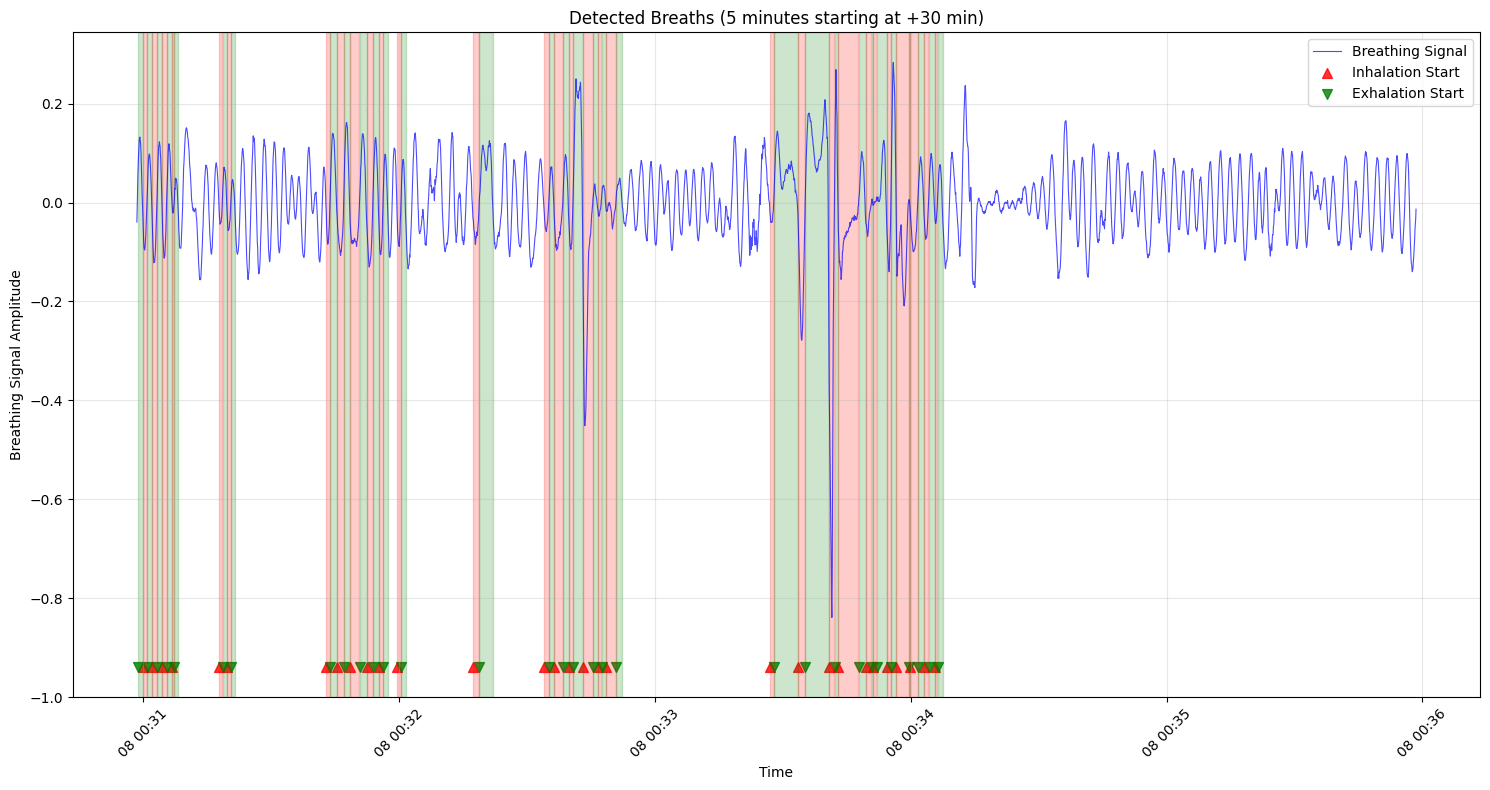


Statistics for 5-minute window:
Inhalations detected: 30
Exhalations detected: 31
Total breath events: 61
Estimated breathing rate: 12.2 breaths/minute


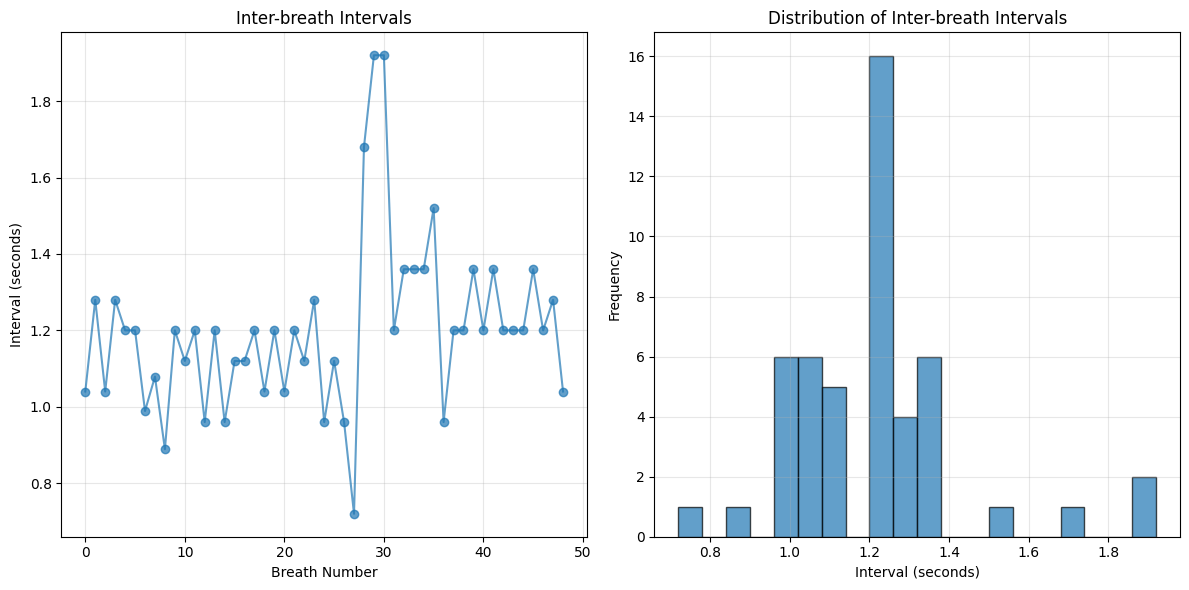

Average interval: 1.20 seconds
Standard deviation: 0.22 seconds
Estimated breathing rate: 50.0 breaths/minute


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta

def plot_detected_breaths(respeck_df, breath_features, start_minutes=0, duration_minutes=5):
    """
    Plot the breathing signal with detected breaths overlaid.
    
    Parameters:
    - respeck_df: DataFrame with timestamp and breathingSignal
    - breath_features: DataFrame from extractFeatures() with startTimestamp, endTimestamp, type
    - start_minutes: Start time offset in minutes from beginning of data
    - duration_minutes: How many minutes of data to plot
    """
    
    # Convert timestamps to datetime if they aren't already
    respeck_df['timestamp'] = pd.to_datetime(respeck_df['timestamp'])
    breath_features['startTimestamp'] = pd.to_datetime(breath_features['startTimestamp'])
    breath_features['endTimestamp'] = pd.to_datetime(breath_features['endTimestamp'])
    
    # Define the time window to plot
    data_start = respeck_df['timestamp'].min()
    plot_start = data_start + timedelta(minutes=start_minutes)
    plot_end = plot_start + timedelta(minutes=duration_minutes)
    
    # Filter the data for the plotting window
    signal_subset = respeck_df[
        (respeck_df['timestamp'] >= plot_start) & 
        (respeck_df['timestamp'] <= plot_end)
    ].copy()
    
    breaths_subset = breath_features[
        (breath_features['startTimestamp'] >= plot_start) & 
        (breath_features['startTimestamp'] <= plot_end)
    ].copy()
    
    if signal_subset.empty:
        print("No data in the specified time range. Try adjusting start_minutes.")
        return
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    # Plot the breathing signal
    plt.plot(signal_subset['timestamp'], signal_subset['breathingSignal'], 
             'b-', linewidth=0.8, label='Breathing Signal', alpha=0.7)
    
    # Plot detected breaths
    colors = {'Inhalation': 'red', 'Exhalation': 'green'}
    markers = {'Inhalation': '^', 'Exhalation': 'v'}
    
    for breath_type in ['Inhalation', 'Exhalation']:
        type_breaths = breaths_subset[breaths_subset['type'] == breath_type]
        if not type_breaths.empty:
            plt.scatter(type_breaths['startTimestamp'], 
                       [signal_subset['breathingSignal'].min() - 0.1] * len(type_breaths),
                       c=colors[breath_type], marker=markers[breath_type], 
                       s=50, label=f'{breath_type} Start', alpha=0.8)
    
    # Add breath duration bars
    for _, breath in breaths_subset.iterrows():
        color = colors[breath['type']]
        plt.axvspan(breath['startTimestamp'], breath['endTimestamp'], 
                   alpha=0.2, color=color)
    
    plt.xlabel('Time')
    plt.ylabel('Breathing Signal Amplitude')
    plt.title(f'Detected Breaths ({duration_minutes} minutes starting at +{start_minutes} min)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print some statistics for this window
    inhalations = breaths_subset[breaths_subset['type'] == 'Inhalation']
    exhalations = breaths_subset[breaths_subset['type'] == 'Exhalation']
    
    print(f"\nStatistics for {duration_minutes}-minute window:")
    print(f"Inhalations detected: {len(inhalations)}")
    print(f"Exhalations detected: {len(exhalations)}")
    print(f"Total breath events: {len(breaths_subset)}")
    print(f"Estimated breathing rate: {(len(inhalations) + len(exhalations)) / duration_minutes:.1f} breaths/minute")


def plot_breath_intervals(breath_features, max_breaths=50):
    """
    Plot the intervals between consecutive breaths to check for regularity.
    """
    # Sort by start timestamp
    breath_features_sorted = breath_features.sort_values('startTimestamp')
    
    # Calculate intervals between consecutive breaths (all types)
    intervals = []
    prev_time = None
    
    for _, breath in breath_features_sorted.head(max_breaths).iterrows():
        current_time = breath['startTimestamp']
        if prev_time is not None:
            interval = (current_time - prev_time).total_seconds()
            intervals.append(interval)
        prev_time = current_time
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(intervals, 'o-', alpha=0.7)
    plt.xlabel('Breath Number')
    plt.ylabel('Interval (seconds)')
    plt.title('Inter-breath Intervals')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(intervals, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Interval (seconds)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Inter-breath Intervals')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Average interval: {np.mean(intervals):.2f} seconds")
    print(f"Standard deviation: {np.std(intervals):.2f} seconds")
    print(f"Estimated breathing rate: {60/np.mean(intervals):.1f} breaths/minute")


def plot_threshold_visualization(respeck_df, start_minutes=0, duration_minutes=2):
    """
    Visualize the adaptive thresholds used by the algorithm.
    """
    # This recreates the threshold calculation from your algorithm
    minThreshold = 0.001
    mult = 0.01
    
    signal = list(respeck_df.breathingSignal)
    
    time_diff = respeck_df['timestamp'].diff()
    window_size = int((10 / time_diff.dropna().apply(lambda x: x.total_seconds()).mean()) // 2)
    
    # Calculate thresholds (using the functions from your code)
    threshs = calculateThresholdLevels(list(signal), window_size, window_size, mult, False)
    posThresh = threshs[:, 0]
    negThresh = threshs[:, 1]
    
    # Define the time window to plot
    data_start = respeck_df['timestamp'].min()
    plot_start = data_start + timedelta(minutes=start_minutes)
    plot_end = plot_start + timedelta(minutes=duration_minutes)
    
    # Get indices for the time window
    start_idx = respeck_df[respeck_df['timestamp'] >= plot_start].index[0]
    end_idx = respeck_df[respeck_df['timestamp'] <= plot_end].index[-1]
    
    # Plot
    plt.figure(figsize=(15, 8))
    
    timestamps = respeck_df.loc[start_idx:end_idx, 'timestamp']
    signal_subset = respeck_df.loc[start_idx:end_idx, 'breathingSignal']
    pos_thresh_subset = posThresh[start_idx:end_idx]
    neg_thresh_subset = negThresh[start_idx:end_idx]
    
    plt.plot(timestamps, signal_subset, 'b-', linewidth=1, label='Breathing Signal')
    plt.plot(timestamps, pos_thresh_subset, 'r--', linewidth=1, label='Positive Threshold', alpha=0.8)
    plt.plot(timestamps, neg_thresh_subset, 'g--', linewidth=1, label='Negative Threshold', alpha=0.8)
    plt.axhline(y=minThreshold, color='orange', linestyle=':', label=f'Min Threshold ({minThreshold})')
    plt.axhline(y=-minThreshold, color='orange', linestyle=':', alpha=0.8)
    
    plt.xlabel('Time')
    plt.ylabel('Signal Amplitude')
    plt.title(f'Breathing Signal with Adaptive Thresholds (mult={mult}, window={window_size})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Usage examples:
# # Plot 5 minutes of data starting from the beginning
# plot_detected_breaths(respeck_df, breath_features, start_minutes=0, duration_minutes=5)

# Plot 5 minutes starting from 30 minutes into the data
plot_detected_breaths(respeck_df, breath_features, start_minutes=30, duration_minutes=5)

# Plot breath intervals
plot_breath_intervals(breath_features)

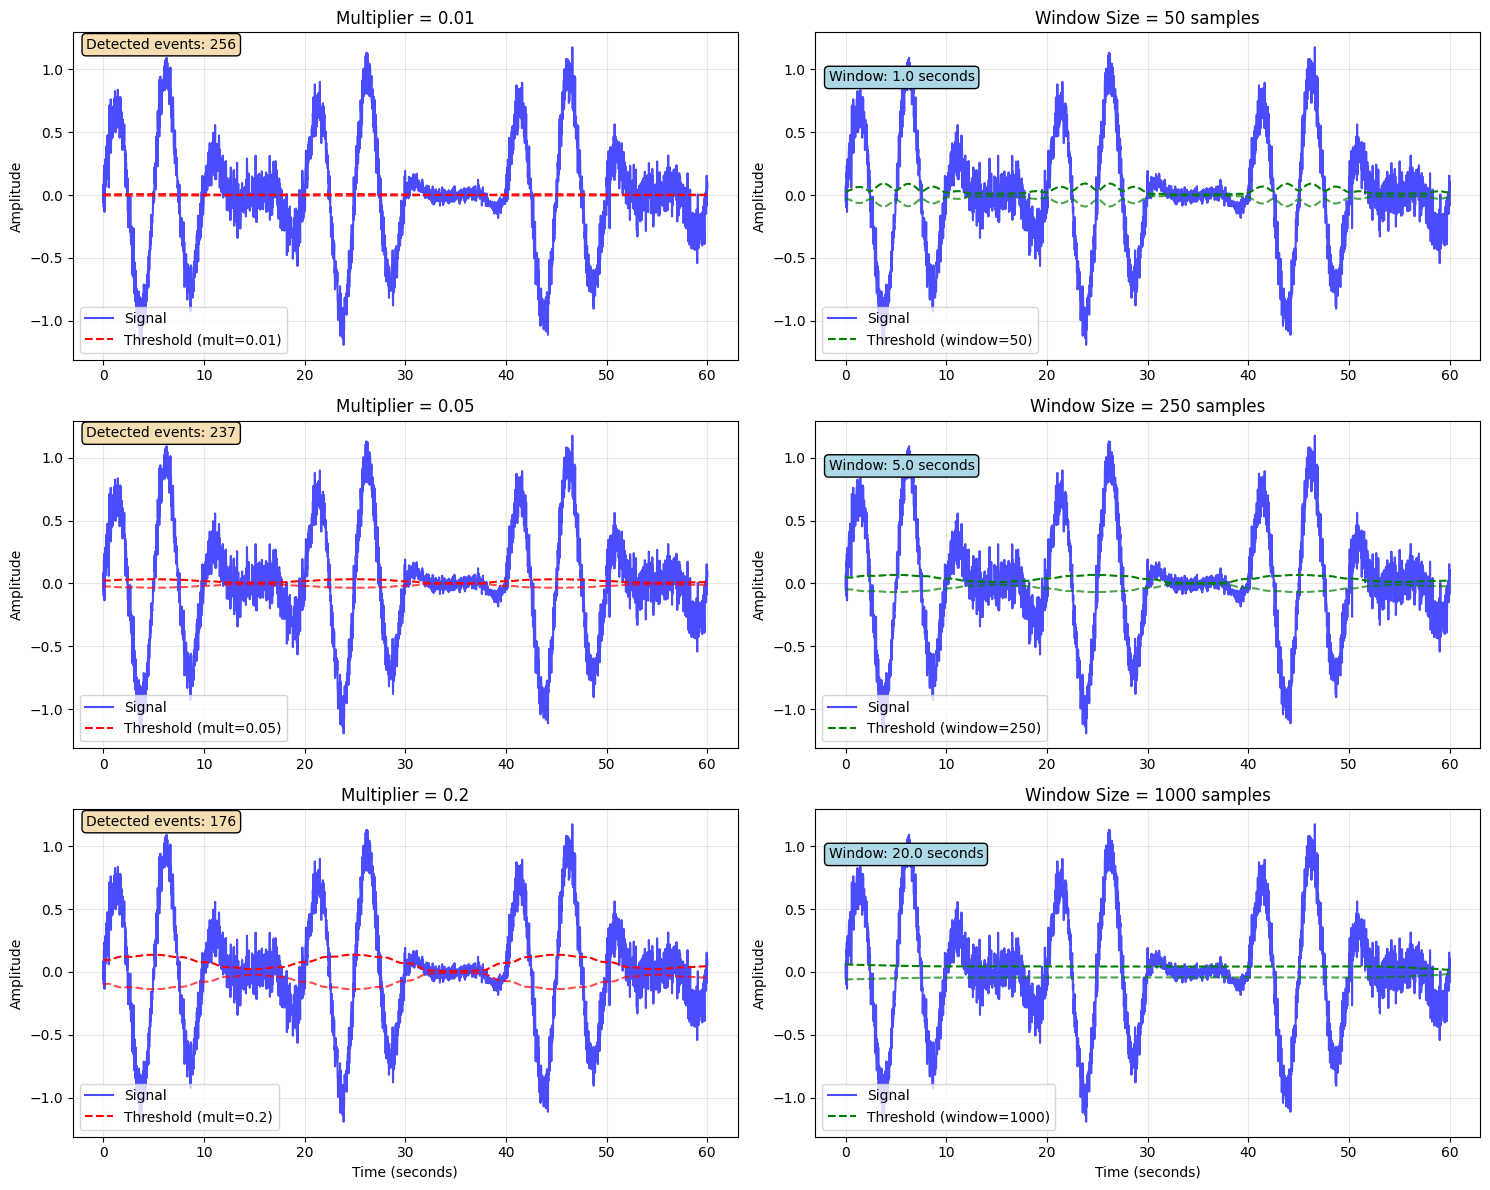

MULTIPLIER EFFECTS (Left Column):
• mult = 0.01: Very sensitive, catches small variations and noise
• mult = 0.05: Moderate sensitivity, good for normal breathing
• mult = 0.2:  Low sensitivity, may miss shallow breaths

WINDOW SIZE EFFECTS (Right Column):
• Small window (1 sec): Highly adaptive, follows signal changes quickly
• Medium window (5 sec): Balanced adaptation, stable but responsive
• Large window (20 sec): Very stable, slow to adapt to changes

TRADE-OFFS:
• Small mult + Small window: Very sensitive, may over-detect
• Large mult + Large window: Very conservative, may under-detect
• Medium values: Usually the sweet spot for real breathing signals


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def demonstrate_parameter_effects():
    """
    Demonstrate how mult and window_size affect breath detection
    """
    
    # Create a synthetic breathing signal with varying amplitudes
    time = np.linspace(0, 60, 3000)  # 1 minute at ~50Hz sampling
    # Main breathing pattern (0.2 Hz = 12 breaths/min)
    breathing = np.sin(2 * np.pi * 0.2 * time)
    
    # Add some amplitude variation (simulating deeper/shallower breaths)
    amplitude_variation = 0.5 + 0.5 * np.sin(2 * np.pi * 0.05 * time)
    breathing = breathing * amplitude_variation
    
    # Add some noise
    noise = 0.1 * np.random.randn(len(time))
    signal = breathing + noise
    
    # Add a period of very shallow breathing
    shallow_start, shallow_end = 1500, 2000
    signal[shallow_start:shallow_end] *= 0.3
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # Different multiplier values
    multipliers = [0.01, 0.05, 0.2]
    window_samples = 250  # Fixed window for multiplier comparison
    
    for i, mult in enumerate(multipliers):
        ax = axes[i, 0]
        
        # Simple threshold calculation (simplified version)
        window_half = window_samples // 2
        thresholds_pos = []
        thresholds_neg = []
        
        for j in range(len(signal)):
            start_idx = max(0, j - window_half)
            end_idx = min(len(signal), j + window_half)
            window_signal = signal[start_idx:end_idx]
            
            # Calculate RMS and apply multiplier
            rms_val = np.sqrt(np.mean(window_signal**2))
            threshold = rms_val * mult
            
            thresholds_pos.append(threshold)
            thresholds_neg.append(-threshold)
        
        # Plot signal and thresholds
        ax.plot(time, signal, 'b-', alpha=0.7, label='Signal')
        ax.plot(time, thresholds_pos, 'r--', label=f'Threshold (mult={mult})')
        ax.plot(time, thresholds_neg, 'r--', alpha=0.7)
        ax.set_title(f'Multiplier = {mult}')
        ax.set_ylabel('Amplitude')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Count threshold crossings (simplified breath detection)
        crossings = 0
        above_threshold = False
        for j in range(1, len(signal)):
            if signal[j] > thresholds_pos[j] and not above_threshold:
                crossings += 1
                above_threshold = True
            elif signal[j] < thresholds_neg[j]:
                above_threshold = False
        
        ax.text(0.02, 0.95, f'Detected events: {crossings}', 
                transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
    
    # Different window sizes
    window_sizes = [50, 250, 1000]  # Small, medium, large windows
    mult_fixed = 0.1  # Fixed multiplier for window comparison
    
    for i, window_samples in enumerate(window_sizes):
        ax = axes[i, 1]
        
        window_half = window_samples // 2
        thresholds_pos = []
        thresholds_neg = []
        
        for j in range(len(signal)):
            start_idx = max(0, j - window_half)
            end_idx = min(len(signal), j + window_half)
            window_signal = signal[start_idx:end_idx]
            
            # Calculate RMS and apply multiplier
            rms_val = np.sqrt(np.mean(window_signal**2))
            threshold = rms_val * mult_fixed
            
            thresholds_pos.append(threshold)
            thresholds_neg.append(-threshold)
        
        # Plot signal and thresholds
        ax.plot(time, signal, 'b-', alpha=0.7, label='Signal')
        ax.plot(time, thresholds_pos, 'g--', label=f'Threshold (window={window_samples})')
        ax.plot(time, thresholds_neg, 'g--', alpha=0.7)
        ax.set_title(f'Window Size = {window_samples} samples')
        ax.set_ylabel('Amplitude')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Show window size in time
        window_time = window_samples / 50  # Assuming 50 Hz sampling
        ax.text(0.02, 0.85, f'Window: {window_time:.1f} seconds', 
                transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor='lightblue'))
    
    # Add x-axis labels to bottom plots
    for ax in axes[2, :]:
        ax.set_xlabel('Time (seconds)')
    
    plt.tight_layout()
    plt.show()
    
    # Print explanations
    print("MULTIPLIER EFFECTS (Left Column):")
    print("• mult = 0.01: Very sensitive, catches small variations and noise")
    print("• mult = 0.05: Moderate sensitivity, good for normal breathing")
    print("• mult = 0.2:  Low sensitivity, may miss shallow breaths")
    print()
    print("WINDOW SIZE EFFECTS (Right Column):")
    print("• Small window (1 sec): Highly adaptive, follows signal changes quickly")
    print("• Medium window (5 sec): Balanced adaptation, stable but responsive")
    print("• Large window (20 sec): Very stable, slow to adapt to changes")
    print()
    print("TRADE-OFFS:")
    print("• Small mult + Small window: Very sensitive, may over-detect")
    print("• Large mult + Large window: Very conservative, may under-detect") 
    print("• Medium values: Usually the sweet spot for real breathing signals")

# Run the demonstration
demonstrate_parameter_effects()

BREATH DETECTION DIAGNOSTIC REPORT
1. DATA QUALITY:
   Total data points: 252278
   Data duration: 5.6 hours
   NaN values: 893 (0.4%)
   Signal range: -18.052038 to 12.374890
   Signal mean: 0.001156
   Signal std: 0.341553
   Signal RMS: 0.341554

2. SAMPLING:
   Average sample period: 0.080 seconds
   Estimated sampling rate: 12.5 Hz

3. SIGNAL CHARACTERISTICS:
   Zero crossings in derivative: 32309
   Estimated oscillations per minute: 96.3

4. THRESHOLD ANALYSIS:
   Threshold range (mult=0.001): -0.004790 to 0.004790
   Signal exceeds positive threshold: 120424 times
   Signal below negative threshold: 116558 times

5. RECOMMENDED ACTIONS:
   - Plot a sample of your signal to visually inspect breathing patterns
   - Check if signal needs preprocessing (filtering, detrending)
   - Verify data units and scaling
   - Consider if algorithm assumptions match your signal characteristics
{'signal_stats': {'min': np.float64(-18.052038), 'max': np.float64(12.37489), 'mean': np.float64(0.00

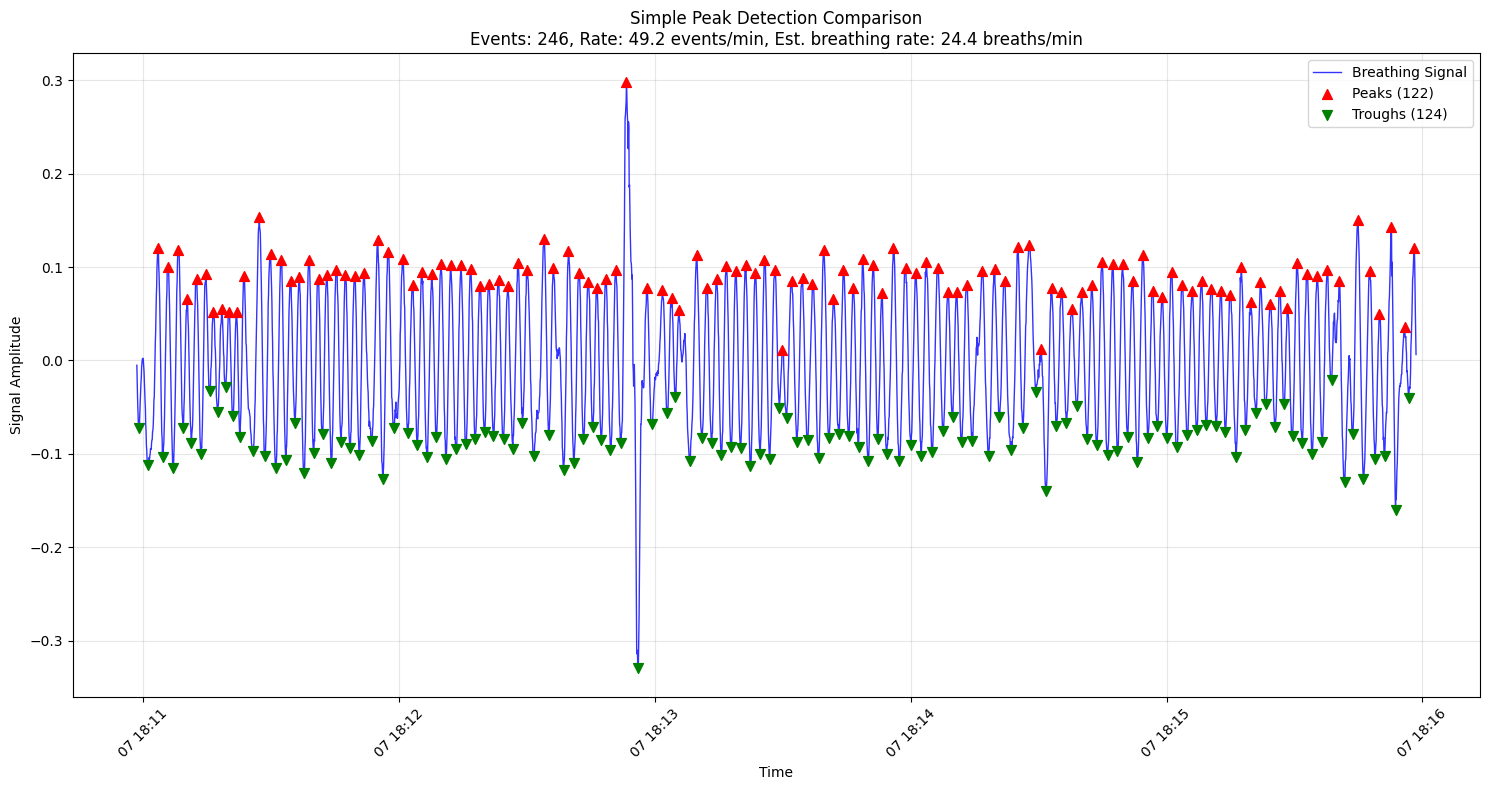

{'peaks': 122, 'troughs': 124, 'events_per_minute': 49.2, 'breaths_per_minute': 24.4}


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def diagnose_breath_detection_issues(df, sample_minutes=5):
    """
    Comprehensive diagnosis of why breath detection is failing
    """
    print("BREATH DETECTION DIAGNOSTIC REPORT")
    print("=" * 50)
    
    # 1. Data Quality Check
    print("1. DATA QUALITY:")
    print(f"   Total data points: {len(df)}")
    print(f"   Data duration: {(df['timestamp'].max() - df['timestamp'].min()).total_seconds()/3600:.1f} hours")
    
    # Check for NaN values
    nan_count = df['breathingSignal'].isna().sum()
    print(f"   NaN values: {nan_count} ({nan_count/len(df)*100:.1f}%)")
    
    # Check signal range and characteristics
    signal = df['breathingSignal'].dropna()
    print(f"   Signal range: {signal.min():.6f} to {signal.max():.6f}")
    print(f"   Signal mean: {signal.mean():.6f}")
    print(f"   Signal std: {signal.std():.6f}")
    print(f"   Signal RMS: {np.sqrt(np.mean(signal**2)):.6f}")
    
    # 2. Sampling Rate Check
    time_diffs = df['timestamp'].diff().dropna()
    avg_sample_period = time_diffs.apply(lambda x: x.total_seconds()).mean()
    sampling_rate = 1 / avg_sample_period if avg_sample_period > 0 else 0
    print(f"\n2. SAMPLING:")
    print(f"   Average sample period: {avg_sample_period:.3f} seconds")
    print(f"   Estimated sampling rate: {sampling_rate:.1f} Hz")
    
    # 3. Signal Variability Check
    print(f"\n3. SIGNAL CHARACTERISTICS:")
    
    # Check if signal has breathing-like oscillations
    signal_diff = np.diff(signal)
    zero_crossings = np.sum(np.diff(np.signbit(signal_diff)))
    expected_crossings_per_minute = zero_crossings / (len(df) * avg_sample_period / 60)
    print(f"   Zero crossings in derivative: {zero_crossings}")
    print(f"   Estimated oscillations per minute: {expected_crossings_per_minute:.1f}")
    
    # 4. Threshold Analysis
    print(f"\n4. THRESHOLD ANALYSIS:")
    
    # Test with extremely low thresholds
    mult_test = 0.001  # Very low threshold
    window_size = int((10 / avg_sample_period) // 2)
    
    threshs = calculateThresholdLevels(list(signal), window_size, window_size, mult_test, True)
    posThresh = threshs[:, 0]
    negThresh = threshs[:, 1]
    
    valid_pos_thresh = posThresh[~np.isnan(posThresh)]
    valid_neg_thresh = negThresh[~np.isnan(negThresh)]
    
    if len(valid_pos_thresh) > 0:
        print(f"   Threshold range (mult={mult_test}): {valid_neg_thresh.min():.6f} to {valid_pos_thresh.max():.6f}")
        print(f"   Signal exceeds positive threshold: {np.sum(signal > valid_pos_thresh.max())} times")
        print(f"   Signal below negative threshold: {np.sum(signal < valid_neg_thresh.min())} times")
    else:
        print("   ⚠️  No valid thresholds calculated!")
    
    # 5. Visual Inspection Helper
    print(f"\n5. RECOMMENDED ACTIONS:")
    print("   - Plot a sample of your signal to visually inspect breathing patterns")
    print("   - Check if signal needs preprocessing (filtering, detrending)")
    print("   - Verify data units and scaling")
    print("   - Consider if algorithm assumptions match your signal characteristics")
    
    return {
        'signal_stats': {
            'min': signal.min(),
            'max': signal.max(),
            'mean': signal.mean(),
            'std': signal.std(),
            'rms': np.sqrt(np.mean(signal**2))
        },
        'sampling_rate': sampling_rate,
        'zero_crossings_per_minute': expected_crossings_per_minute
    }

def plot_signal_with_simple_detection(df, start_minutes=10, duration_minutes=5):
    """
    Plot signal with very simple peak detection for comparison
    """
    from scipy.signal import find_peaks
    
    # Get time window
    data_start = df['timestamp'].min()
    plot_start = data_start + pd.Timedelta(minutes=start_minutes)
    plot_end = plot_start + pd.Timedelta(minutes=duration_minutes)
    
    # Filter data
    plot_df = df[(df['timestamp'] >= plot_start) & (df['timestamp'] <= plot_end)].copy()
    
    if plot_df.empty:
        print("No data in specified window")
        return
    
    signal = plot_df['breathingSignal'].values
    timestamps = plot_df['timestamp'].values
    
    # Simple peak detection for comparison
    # Find peaks (inspiration)
    peaks, _ = find_peaks(signal, height=np.std(signal)*0.1, distance=20)
    # Find troughs (expiration)  
    troughs, _ = find_peaks(-signal, height=np.std(signal)*0.1, distance=20)
    
    plt.figure(figsize=(15, 8))
    
    # Plot signal
    plt.plot(timestamps, signal, 'b-', linewidth=1, label='Breathing Signal', alpha=0.8)
    
    # Plot detected peaks and troughs
    if len(peaks) > 0:
        plt.scatter(timestamps[peaks], signal[peaks], c='red', marker='^', 
                   s=50, label=f'Peaks ({len(peaks)})', zorder=5)
    
    if len(troughs) > 0:
        plt.scatter(timestamps[troughs], signal[troughs], c='green', marker='v', 
                   s=50, label=f'Troughs ({len(troughs)})', zorder=5)
    
    # Add statistics
    total_events = len(peaks) + len(troughs)
    events_per_minute = total_events / duration_minutes
    breaths_per_minute = min(len(peaks), len(troughs)) / duration_minutes  # Use minimum of peaks/troughs
    
    plt.title(f'Simple Peak Detection Comparison\n'
              f'Events: {total_events}, Rate: {events_per_minute:.1f} events/min, '
              f'Est. breathing rate: {breaths_per_minute:.1f} breaths/min')
    plt.xlabel('Time')
    plt.ylabel('Signal Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return {
        'peaks': len(peaks),
        'troughs': len(troughs),
        'events_per_minute': events_per_minute,
        'breaths_per_minute': breaths_per_minute
    }

# Usage:
# 1. Run comprehensive diagnosis
stats = diagnose_breath_detection_issues(respeck_df)
print(stats)
# 2. Plot with simple peak detection for comparison  
simple_results = plot_signal_with_simple_detection(respeck_df, start_minutes=10, duration_minutes=5)
print(simple_results)

## Accelerometer

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, detrend, butter, filtfilt
from skimage.filters import threshold_otsu
import warnings

def _calibrate_orientation_thresholds_with_accelerometer(signal, sampling_rate, accel_x, accel_y, accel_z, fallback_low=0.15, fallback_high=0.5):
    """
    Enhanced version that combines Otsu's method on breathing signal DC offset
    with accelerometer data for more accurate orientation classification.
    
    Parameters:
    - signal: Breathing signal array
    - sampling_rate: Sampling rate in Hz
    - accel_x, accel_y, accel_z: Accelerometer data arrays (same length as signal)
    - fallback_low, fallback_high: Fallback thresholds if calibration fails
    
    Returns:
    - (low_threshold, high_threshold): Enhanced orientation thresholds
    - orientation_info: Dictionary with accelerometer analysis
    """
    
    print("🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA")
    print("=" * 55)
    
    try:
        # === STEP 1: Original Otsu method on breathing signal ===
        window_len = int(15 * sampling_rate)
        if len(signal) < window_len * 2:
            raise ValueError("Signal too short for robust calibration.")
        
        # Calculate DC offset using moving average
        dc_series = np.convolve(signal, np.ones(window_len) / window_len, mode='valid')
        abs_dc_series = np.abs(dc_series)
        
        if np.std(abs_dc_series) < 1e-4:
            raise ValueError("No significant change in DC offset.")
        
        # Apply Otsu's method to breathing signal
        scaler = 10000
        scaled_data = (abs_dc_series * scaler).astype(int)
        otsu_threshold_scaled = threshold_otsu(scaled_data)
        otsu_threshold = otsu_threshold_scaled / scaler
        
        print(f"✅ Otsu threshold from breathing signal: {otsu_threshold:.4f}")
        
        # === STEP 2: Analyze accelerometer data ===
        print(f"\n📊 ACCELEROMETER ANALYSIS:")
        
        # Calculate gravity vector magnitude and dominant axis
        gravity_magnitude = np.sqrt(accel_x**2 + accel_y**2 + accel_z**2)
        avg_gravity = np.mean(gravity_magnitude)
        
        # Smooth accelerometer data for orientation analysis
        smooth_window = min(window_len, len(accel_x) // 10)
        if smooth_window > 5:
            from scipy.signal import savgol_filter
            if smooth_window % 2 == 0:
                smooth_window += 1
            accel_x_smooth = savgol_filter(accel_x, smooth_window, 3)
            accel_y_smooth = savgol_filter(accel_y, smooth_window, 3)
            accel_z_smooth = savgol_filter(accel_z, smooth_window, 3)
        else:
            accel_x_smooth = accel_x
            accel_y_smooth = accel_y
            accel_z_smooth = accel_z
        
        # Calculate average orientations
        avg_x = np.mean(accel_x_smooth)
        avg_y = np.mean(accel_y_smooth)
        avg_z = np.mean(accel_z_smooth)
        
        print(f"Average gravity magnitude: {avg_gravity:.3f}g")
        print(f"Average orientation: [{avg_x:.3f}, {avg_y:.3f}, {avg_z:.3f}]")
        
        # === STEP 3: Classify body orientation using accelerometer ===
        abs_x, abs_y, abs_z = abs(avg_x), abs(avg_y), abs(avg_z)
        
        if abs_z > 0.8:  # Lying flat
            if avg_z < -0.8:
                orientation_type = "supine"  # Back (sensor facing up)
                gravity_influence = "high"
            elif avg_z > 0.8:
                orientation_type = "prone"   # Stomach (sensor facing down) 
                gravity_influence = "high"
            else:
                orientation_type = "mixed"
                gravity_influence = "medium"
        elif abs_x > 0.6:  # Side lying
            if avg_x < -0.6:
                orientation_type = "left_side"
            else:
                orientation_type = "right_side"
            gravity_influence = "medium"
        else:
            orientation_type = "mixed"
            gravity_influence = "low"
        
        print(f"Detected orientation: {orientation_type}")
        print(f"Gravity influence: {gravity_influence}")
        
        # === STEP 4: Adjust Otsu thresholds based on accelerometer orientation ===
        if gravity_influence == "high":
            # Strong gravity effects - need higher thresholds and filtering
            threshold_multiplier = 1.5
            low_threshold = otsu_threshold * threshold_multiplier
            high_threshold = low_threshold + 0.1
            preprocessing_needed = "high_pass_filter"
            
        elif gravity_influence == "medium": 
            # Moderate gravity effects - use Otsu threshold as-is
            threshold_multiplier = 1.0
            low_threshold = otsu_threshold
            high_threshold = low_threshold + 0.05
            preprocessing_needed = "detrend_only"
            
        else:  # gravity_influence == "low"
            # Minimal gravity effects - can use lower thresholds
            threshold_multiplier = 0.8
            low_threshold = otsu_threshold * threshold_multiplier
            high_threshold = low_threshold + 0.03
            preprocessing_needed = "minimal"
        
        # Sanity checks
        if low_threshold >= high_threshold or high_threshold > 2.0 or low_threshold < 0.01:
            raise ValueError("Calibrated thresholds are not plausible.")
        
        print(f"\n✅ ENHANCED CALIBRATION RESULTS:")
        print(f"Orientation-adjusted low threshold: {low_threshold:.4f}")
        print(f"Orientation-adjusted high threshold: {high_threshold:.4f}")
        print(f"Recommended preprocessing: {preprocessing_needed}")
        
        # Create orientation info dictionary
        orientation_info = {
            'orientation_type': orientation_type,
            'gravity_influence': gravity_influence,
            'avg_orientation': [avg_x, avg_y, avg_z],
            'avg_gravity_magnitude': avg_gravity,
            'otsu_threshold_original': otsu_threshold,
            'threshold_multiplier': threshold_multiplier,
            'preprocessing_needed': preprocessing_needed
        }
        
        return (low_threshold, high_threshold), orientation_info
        
    except Exception as e:
        print(f"⚠️  Enhanced calibration failed ({e}). Using fallback thresholds.")
        
        # Fallback orientation analysis
        if len(accel_x) > 0:
            avg_x = np.mean(accel_x)
            avg_z = np.mean(accel_z)
            if abs(avg_z) > 0.7:
                orientation_type = "supine" if avg_z < 0 else "prone"
                gravity_influence = "high"
            else:
                orientation_type = "side"
                gravity_influence = "medium"
        else:
            orientation_type = "unknown"
            gravity_influence = "medium"
        
        orientation_info = {
            'orientation_type': orientation_type,
            'gravity_influence': gravity_influence,
            'avg_orientation': [0, 0, -1],
            'preprocessing_needed': 'detrend_only',
            'fallback_used': True
        }
        
        return (fallback_low, fallback_high), orientation_info

def adaptive_breath_detection_enhanced_otsu(df, adaptation_window_minutes=10, 
                                           sensitivity='medium', method='peaks'):
    """
    Enhanced adaptive breath detection using Otsu method combined with accelerometer data
    """
    
    print("🚀 ENHANCED ADAPTIVE BREATH DETECTION (OTSU + ACCELEROMETER)")
    print("=" * 65)
    
    # Input validation
    required_columns = ['breathingSignal', 'timestamp']
    accelerometer_columns = ['x', 'y', 'z']
    
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain columns: {required_columns}")
    
    print(f"✅ Found accelerometer data: {accelerometer_columns}")
    
    # Clean signal
    signal_series = df['breathingSignal'].copy().replace([np.inf, -np.inf], np.nan)
    valid_signal = signal_series.dropna()
    
    if len(valid_signal) < 200:
        raise ValueError(f"Insufficient valid samples: {len(valid_signal)}")
    
    signal = valid_signal.values
    valid_indices = valid_signal.index
    timestamps = df.loc[valid_indices, 'timestamp'].values
    
    # Get accelerometer data aligned with valid signal
    accel_x = df.loc[valid_indices, 'x'].values
    accel_y = df.loc[valid_indices, 'y'].values
    accel_z = df.loc[valid_indices, 'z'].values
    
    # Get activity data if available
    activity_level = None
    if 'activityLevel' in df.columns:
        activity_level = df.loc[valid_indices, 'activityLevel'].values
    
    # Calculate sampling rate
    time_diffs = pd.Series(timestamps).diff().dropna()
    avg_sample_period = time_diffs.apply(lambda x: x.total_seconds()).median()
    if pd.isna(avg_sample_period) or avg_sample_period <= 0:
        avg_sample_period = 0.02  # 50 Hz fallback
    sampling_rate = 1 / avg_sample_period
    
    print(f"📊 Data summary: {len(valid_signal):,} samples at {sampling_rate:.1f} Hz")
    
    # === ENHANCED OTSU CALIBRATION ===
    (low_orientation_thresh, high_orientation_thresh), orientation_info = _calibrate_orientation_thresholds_with_accelerometer(
        signal, sampling_rate, accel_x, accel_y, accel_z
    )
    
    # Calculate adaptation window size
    adaptation_window_samples = int(adaptation_window_minutes * 60 * sampling_rate)
    adaptation_window_samples = min(adaptation_window_samples, len(signal) // 4)
    
    # Sensitivity settings
    sensitivity_params = {
        'low': {'base_height': 0.6, 'base_prominence': 0.5},
        'medium': {'base_height': 0.5, 'base_prominence': 0.4},
        'high': {'base_height': 0.4, 'base_prominence': 0.3}
    }
    params = sensitivity_params.get(sensitivity, sensitivity_params['medium'])
    
    # Process signal in overlapping windows
    all_breath_events = []
    step_size = adaptation_window_samples // 4  # 75% overlap
    window_start = 0
    
    while window_start + adaptation_window_samples <= len(signal):
        window_end = window_start + adaptation_window_samples
        window_signal = signal[window_start:window_end]
        window_timestamps = timestamps[window_start:window_end]
        window_activity = activity_level[window_start:window_end] if activity_level is not None else None
        
        # Analyze window characteristics
        detrended_signal = detrend(window_signal, type='constant')
        signal_mean = np.mean(window_signal)
        signal_std = np.std(detrended_signal)
        signal_abs_mean = abs(signal_mean)
        
        # Use enhanced orientation classification
        gravity_influence = orientation_info['gravity_influence']
        
        if gravity_influence == 'high':
            min_amplitude = 0.015
            base_height_factor = 0.25
            base_prominence_factor = 0.2
        elif gravity_influence == 'medium':
            min_amplitude = 0.008
            base_height_factor = 0.15
            base_prominence_factor = 0.12
        else:  # gravity_influence == 'low'
            min_amplitude = 0.005
            base_height_factor = 0.1
            base_prominence_factor = 0.08
        
        # Activity-based adjustment
        if window_activity is not None:
            avg_activity = np.mean(window_activity)
            if avg_activity > 0.1:
                activity_factor = 1.3
            elif avg_activity > 0.03:
                activity_factor = 1.0
            else:
                activity_factor = 0.8
        else:
            activity_factor = 1.0
        
        # Signal quality adjustment
        signal_diff = np.diff(detrended_signal)
        noise_estimate = np.std(signal_diff) * np.sqrt(2)
        snr = signal_std / (noise_estimate + 1e-10)
        
        if snr < 2:
            quality_factor = 1.4
        elif snr < 4:
            quality_factor = 1.0
        else:
            quality_factor = 0.8
        
        # Sleep factor
        sleep_factor = 0.9
        
        # Combine factors
        combined_factor = (sleep_factor * activity_factor * quality_factor * 
                          params['base_height'] * base_height_factor)
        
        # Calculate adaptive thresholds
        height_threshold = max(signal_std * combined_factor, min_amplitude * 0.3)
        prominence_threshold = max(signal_std * combined_factor * 0.8, min_amplitude * 0.15)
        
        # Adaptive minimum distance
        base_distance_sec = 1.5
        if gravity_influence == 'high':
            base_distance_sec = 1.8
        elif gravity_influence == 'low':
            base_distance_sec = 1.2
        min_distance = max(5, int(base_distance_sec * sampling_rate))
        
        # Apply enhanced preprocessing based on orientation
        processed_signal = detrend(window_signal, type='constant')
        
        preprocessing_needed = orientation_info.get('preprocessing_needed', 'detrend_only')
        if preprocessing_needed == 'high_pass_filter':
            try:
                cutoff = 0.05
                nyquist = sampling_rate / 2
                normalized_cutoff = cutoff / nyquist
                if normalized_cutoff < 1.0:
                    b, a = butter(2, normalized_cutoff, btype='high')
                    processed_signal = filtfilt(b, a, processed_signal)
            except:
                pass
        
        # Detect peaks and troughs
        try:
            peaks, _ = find_peaks(
                processed_signal,
                height=height_threshold,
                distance=min_distance,
                prominence=prominence_threshold,
                width=2
            )
            
            troughs, _ = find_peaks(
                -processed_signal,
                height=height_threshold,
                distance=min_distance,
                prominence=prominence_threshold,
                width=2
            )
            
            # Validate detected events
            validation_threshold = height_threshold * 1.5
            
            valid_peaks = [p for p in peaks if processed_signal[p] > validation_threshold]
            valid_troughs = [t for t in troughs if abs(processed_signal[t]) > validation_threshold]
            
            # Add breath events with orientation info
            for peak_idx in valid_peaks:
                global_idx = window_start + peak_idx
                if global_idx < len(timestamps):
                    all_breath_events.append({
                        'type': 'Inhalation',
                        'index': valid_indices[global_idx],
                        'timestamp': timestamps[global_idx],
                        'amplitude': processed_signal[peak_idx],
                        'raw_amplitude': signal[global_idx],
                        'event_type': 'peak',
                        'orientation_type': orientation_info['orientation_type'],
                        'gravity_influence': gravity_influence
                    })
            
            for trough_idx in valid_troughs:
                global_idx = window_start + trough_idx
                if global_idx < len(timestamps):
                    all_breath_events.append({
                        'type': 'Exhalation',
                        'index': valid_indices[global_idx],
                        'timestamp': timestamps[global_idx],
                        'amplitude': processed_signal[trough_idx],
                        'raw_amplitude': signal[global_idx],
                        'event_type': 'trough',
                        'orientation_type': orientation_info['orientation_type'],
                        'gravity_influence': gravity_influence
                    })
        
        except:
            pass
        
        window_start += step_size
    
    # Remove duplicate events from overlapping windows
    if not all_breath_events:
        return pd.DataFrame(), {
            'total_events': 0, 'breathing_cycles': 0, 'events_per_minute': 0,
            'breaths_per_minute': 0, 'duration_minutes': 0, 'error': 'No events detected'
        }
    
    # Sort and filter events
    all_breath_events.sort(key=lambda x: x['timestamp'])
    
    filtered_events = []
    last_timestamp = None
    min_event_spacing = pd.Timedelta(seconds=0.5)
    
    for event in all_breath_events:
        if last_timestamp is None or (event['timestamp'] - last_timestamp) > min_event_spacing:
            filtered_events.append(event)
            last_timestamp = event['timestamp']
    
    # Create output DataFrame
    breath_df = pd.DataFrame(filtered_events)
    if not breath_df.empty:
        breath_df = breath_df.sort_values('timestamp').reset_index(drop=True)
    
    # Calculate statistics
    total_events = len(filtered_events)
    inhalations = len([e for e in filtered_events if e['type'] == 'Inhalation'])
    exhalations = len([e for e in filtered_events if e['type'] == 'Exhalation'])
    breathing_cycles = min(inhalations, exhalations)
    
    duration_minutes = (timestamps[-1] - timestamps[0]) / pd.Timedelta(minutes=1)
    if duration_minutes <= 0:
        duration_minutes = len(timestamps) * avg_sample_period / 60
    
    events_per_minute = total_events / duration_minutes if duration_minutes > 0 else 0
    breaths_per_minute = breathing_cycles / duration_minutes if duration_minutes > 0 else 0
    
    stats = {
        'total_events': total_events,
        'breathing_cycles': breathing_cycles,
        'events_per_minute': events_per_minute,
        'breaths_per_minute': breaths_per_minute,
        'duration_minutes': duration_minutes,
        'inhalations': inhalations,
        'exhalations': exhalations,
        'method': method,
        'sensitivity': sensitivity,
        'sampling_rate': sampling_rate,
        'adaptation_window_minutes': adaptation_window_minutes,
        'orientation_info': orientation_info,  # Include orientation analysis
        'error': None
    }
    
    print(f"\n✅ ENHANCED DETECTION COMPLETE:")
    print(f"Detected {total_events:,} breath events ({breathing_cycles:,} cycles)")
    print(f"Breathing rate: {breaths_per_minute:.1f} breaths/min")
    print(f"Orientation: {orientation_info['orientation_type']} ({orientation_info['gravity_influence']} gravity influence)")
    
    return breath_df, stats

# Usage:
breath_df, stats = adaptive_breath_detection_enhanced_otsu(respeck_df, adaptation_window_minutes=10)
print(f"Breathing rate: {stats['breaths_per_minute']:.1f} breaths/min")


🚀 ENHANCED ADAPTIVE BREATH DETECTION (OTSU + ACCELEROMETER)
✅ Found accelerometer data: ['x', 'y', 'z']
📊 Data summary: 251,385 samples at 12.5 Hz
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.3865

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.004g
Average orientation: [-0.014, -0.129, -0.388]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.3092
Orientation-adjusted high threshold: 0.3392
Recommended preprocessing: minimal

✅ ENHANCED DETECTION COMPLETE:
Detected 12,412 breath events (6,193 cycles)
Breathing rate: 18.5 breaths/min
Orientation: mixed (low gravity influence)
Breathing rate: 18.5 breaths/min


CORRECTED BREATHING RATE COMPARISON OVER TIME
📊 Processing RESpeck sensor data...
✅ Found 5,405 valid RESpeck measurements
   Time range: 2025-05-08 00:01:00.082000+06:00 to 2025-05-08 05:36:27.565000+06:00
   Rate range: 6.7 - 44.4 breaths/min

🤖 Running adaptive algorithm...
🚀 ENHANCED ADAPTIVE BREATH DETECTION (OTSU + ACCELEROMETER)
✅ Found accelerometer data: ['x', 'y', 'z']
📊 Data summary: 251,385 samples at 12.5 Hz
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.3865

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.004g
Average orientation: [-0.014, -0.129, -0.388]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.3092
Orientation-adjusted high threshold: 0.3392
Recommended preprocessing: minimal

✅ ENHANCED DETECTION COMPLETE:
Detected 12,412 breath events (6,193 cycles)
Breathing rate: 18.5 breaths/min
Orientation: mixed (low gravity influence)
✅ Algorith

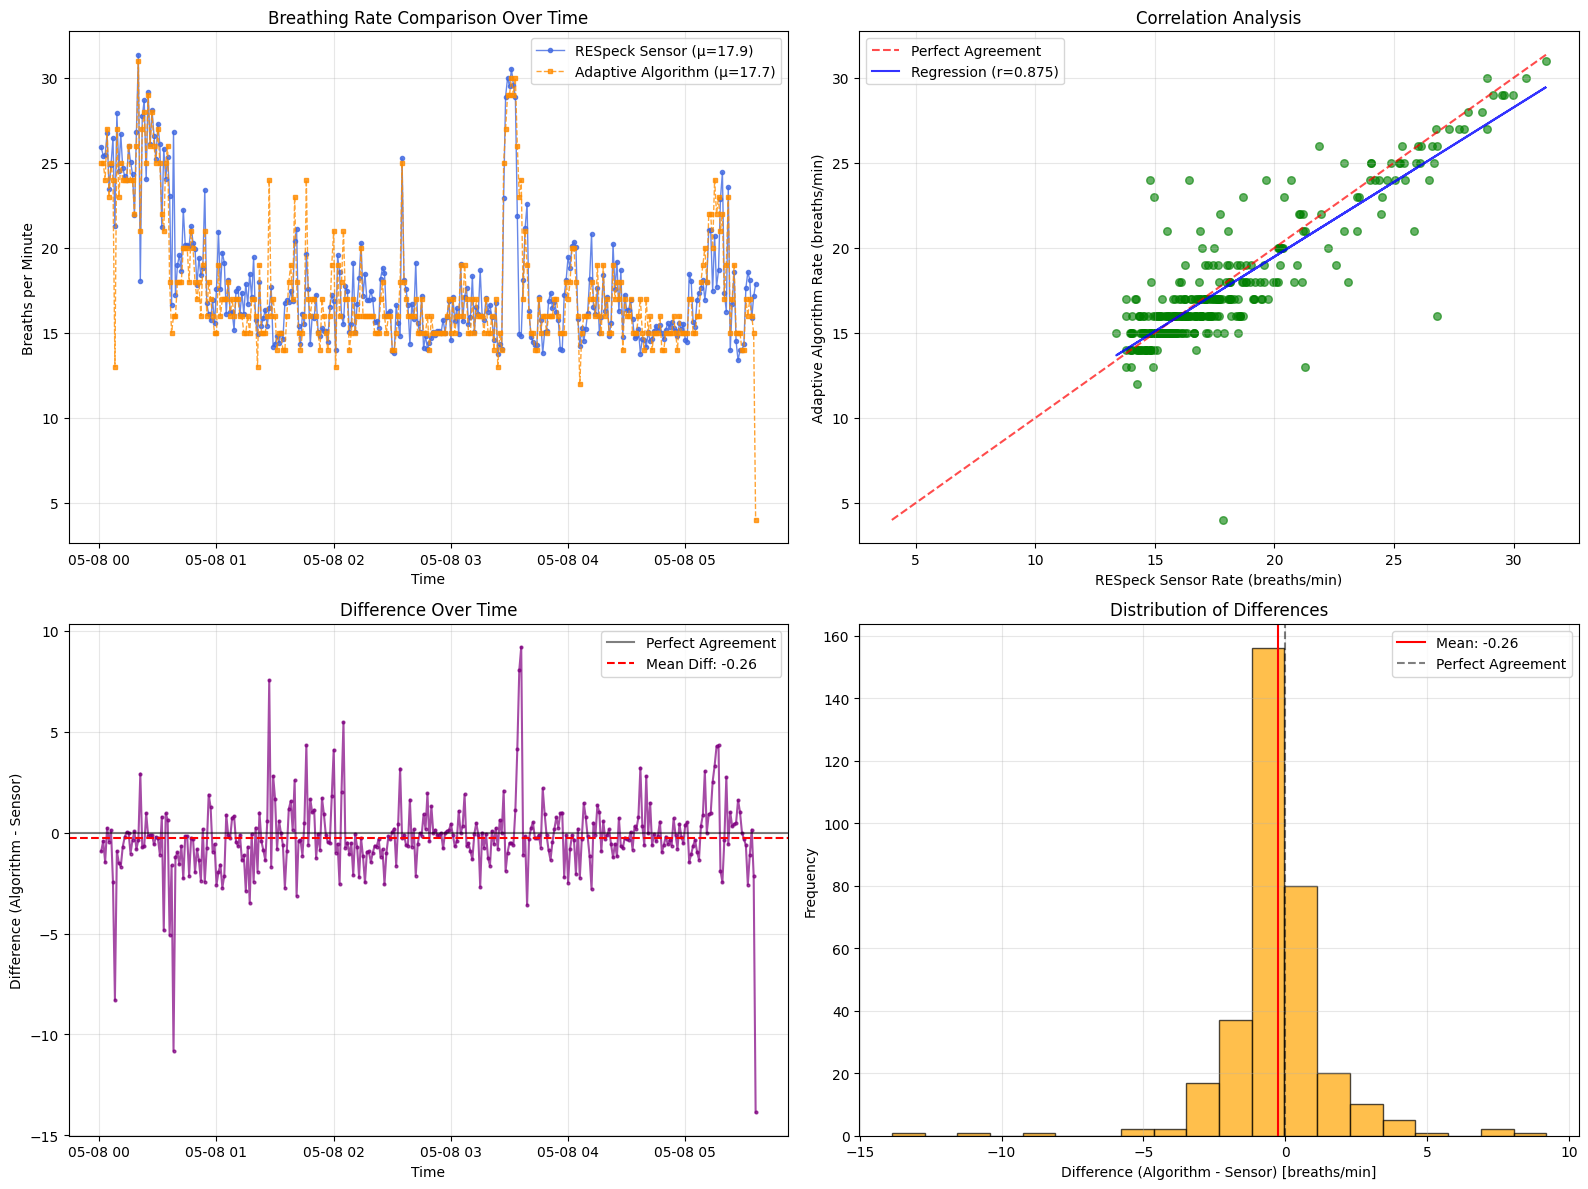

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

def compare_breathing_rates_over_time_corrected(df, window='1min', debug=False):
    """
    Corrected version that properly compares RESpeck sensor breathing rates
    with adaptive algorithm breathing rates over time.
    
    Key corrections:
    1. Counts full breathing cycles (not just inhalations)
    2. Proper timezone handling
    3. Better resampling strategy
    4. More robust comparison metrics
    """
    
    print("CORRECTED BREATHING RATE COMPARISON OVER TIME")
    print("=" * 50)
    
    # --- 1. Process RESpeck Sensor Data ---
    print("📊 Processing RESpeck sensor data...")
    
    respeck_sensor_data = df[['timestamp', 'breathingRate']].copy()
    respeck_sensor_data['breathingRate'] = pd.to_numeric(respeck_sensor_data['breathingRate'], errors='coerce')
    
    # Only keep valid breathing rate measurements
    valid_respeck = respeck_sensor_data.dropna(subset=['breathingRate'])
    
    if valid_respeck.empty:
        print("❌ No valid RESpeck breathing rate data available")
        return None
    
    print(f"✅ Found {len(valid_respeck):,} valid RESpeck measurements")
    print(f"   Time range: {valid_respeck['timestamp'].min()} to {valid_respeck['timestamp'].max()}")
    print(f"   Rate range: {valid_respeck['breathingRate'].min():.1f} - {valid_respeck['breathingRate'].max():.1f} breaths/min")
    
    # Create time series - NO forward fill to avoid propagating stale data
    respeck_rate_series = valid_respeck.set_index('timestamp')['breathingRate'].resample(window).mean()
    
    # --- 2. Process Adaptive Algorithm Data ---
    print("\n🤖 Running adaptive algorithm...")
    
    # Use your existing function name (assuming it's available)
    try:
        breath_df, stats = adaptive_breath_detection_enhanced_otsu(df, adaptation_window_minutes=10)
    except NameError:
        print("❌ adaptive_breath_detection function not found. Please make sure it's defined.")
        return None
    
    breath_df['timestamp'] = breath_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bishkek')

    if breath_df.empty:
        print("❌ Adaptive algorithm detected no breaths")
        return None
    
    print(f"✅ Algorithm detected {len(breath_df):,} breath events")
    print(f"   {stats['inhalations']} inhalations, {stats['exhalations']} exhalations")
    print(f"   Overall rate: {stats['breaths_per_minute']:.1f} breaths/min")
    
    # --- 3. CRITICAL FIX: Count breathing cycles, not just inhalations ---
    breath_df_copy = breath_df.copy()
    
    # Ensure timezone compatibility
    if hasattr(valid_respeck['timestamp'].dtype, 'tz') and valid_respeck['timestamp'].dtype.tz is not None:
        # RESpeck has timezone, ensure breath_df matches
        if not (hasattr(breath_df_copy['timestamp'].dtype, 'tz') and breath_df_copy['timestamp'].dtype.tz is not None):
            breath_df_copy['timestamp'] = breath_df_copy['timestamp'].dt.tz_localize(valid_respeck['timestamp'].dtype.tz)
            if debug:
                print("🔧 Aligned algorithm timestamps with RESpeck timezone")
    else:
        # RESpeck is timezone-naive, ensure breath_df is too
        if hasattr(breath_df_copy['timestamp'].dtype, 'tz') and breath_df_copy['timestamp'].dtype.tz is not None:
            breath_df_copy['timestamp'] = breath_df_copy['timestamp'].dt.tz_localize(None)
            if debug:
                print("🔧 Converted algorithm timestamps to timezone-naive")
    
    # Calculate breathing cycles per minute (proper method)
    breath_df_indexed = breath_df_copy.set_index('timestamp')
    
    # Resample and count both inhalations and exhalations
    inhalations_per_min = breath_df_indexed[breath_df_indexed['type'] == 'Inhalation'].resample(window).size()
    exhalations_per_min = breath_df_indexed[breath_df_indexed['type'] == 'Exhalation'].resample(window).size()
    
    # Breathing rate = minimum of inhalations and exhalations (complete cycles)
    algo_rate_series = pd.DataFrame({'inhalations': inhalations_per_min, 'exhalations': exhalations_per_min}).min(axis=1)
    
    if debug:
        print(f"   Algorithm time range: {breath_df_copy['timestamp'].min()} to {breath_df_copy['timestamp'].max()}")
    
    # --- 4. Combine Data for Comparison ---
    print(f"\n🔗 Combining data for comparison...")
    
    # Find overlapping time period
    respeck_start = respeck_rate_series.index.min()
    respeck_end = respeck_rate_series.index.max()
    algo_start = algo_rate_series.index.min()
    algo_end = algo_rate_series.index.max()
    
    overlap_start = max(respeck_start, algo_start)
    overlap_end = min(respeck_end, algo_end)
    
    print(f"   RESpeck data: {respeck_start} to {respeck_end}")
    print(f"   Algorithm data: {algo_start} to {algo_end}")
    print(f"   Overlap period: {overlap_start} to {overlap_end}")
    
    if overlap_start >= overlap_end:
        print("❌ No temporal overlap between datasets!")
        return None
    
    # Create comparison DataFrame for overlap period only
    comparison_df = pd.DataFrame({
        'respeck_sensor_rate': respeck_rate_series,
        'adaptive_algo_rate': algo_rate_series
    })
    
    # Filter to overlap period and remove NaN values
    comparison_df = comparison_df.loc[overlap_start:overlap_end].dropna()
    
    if comparison_df.empty:
        print("❌ No valid comparison points in overlap period")
        return None
    
    print(f"✅ Found {len(comparison_df):,} valid comparison points")
    
    # --- 5. Statistical Analysis ---
    print(f"\n📈 STATISTICAL ANALYSIS:")
    
    respeck_values = comparison_df['respeck_sensor_rate'].values
    adaptive_values = comparison_df['adaptive_algo_rate'].values
    
    # Basic statistics
    respeck_mean = np.mean(respeck_values)
    adaptive_mean = np.mean(adaptive_values)
    respeck_std = np.std(respeck_values)
    adaptive_std = np.std(adaptive_values)
    
    # Comparison metrics
    difference = adaptive_mean - respeck_mean
    percent_diff = (difference / respeck_mean) * 100 if respeck_mean != 0 else float('inf')
    mae = np.mean(np.abs(adaptive_values - respeck_values))
    rmse = np.sqrt(np.mean((adaptive_values - respeck_values)**2))
    
    # Correlation
    if len(respeck_values) > 1 and len(adaptive_values) > 1:
        correlation, p_value = pearsonr(respeck_values, adaptive_values)
    else:
        correlation, p_value = 0, 1
    
    # Clinical agreement
    within_2_bpm = np.sum(np.abs(adaptive_values - respeck_values) <= 2) / len(adaptive_values) * 100
    within_3_bpm = np.sum(np.abs(adaptive_values - respeck_values) <= 3) / len(adaptive_values) * 100
    
    print(f"RESpeck sensor (mean ± std): {respeck_mean:.1f} ± {respeck_std:.1f} breaths/min")
    print(f"Adaptive algorithm (mean ± std): {adaptive_mean:.1f} ± {adaptive_std:.1f} breaths/min")
    print(f"")
    print(f"Mean difference: {difference:+.1f} breaths/min ({percent_diff:+.1f}%)")
    print(f"Mean Absolute Error: {mae:.2f} breaths/min")
    print(f"Root Mean Square Error: {rmse:.2f} breaths/min")
    print(f"Correlation: {correlation:.3f} (p={p_value:.3f})")
    print(f"")
    print(f"Clinical Agreement:")
    print(f"  Within ±2 breaths/min: {within_2_bpm:.1f}%")
    print(f"  Within ±3 breaths/min: {within_3_bpm:.1f}%")
    
    # Overall assessment
    print(f"\n🎯 OVERALL ASSESSMENT:")
    if abs(difference) < 1 and correlation > 0.7:
        print("✅ Excellent agreement!")
    elif abs(difference) < 2 and correlation > 0.5:
        print("🟡 Good agreement")
    elif abs(difference) < 4 and correlation > 0.3:
        print("🟠 Moderate agreement")
    else:
        print("❌ Poor agreement - needs investigation")
    
    # --- 6. Visualizations ---
    create_comparison_plots(comparison_df, correlation, respeck_mean, adaptive_mean)
    
    # --- 7. Return Results ---
    results = {
        'comparison_df': comparison_df,
        'respeck_mean': respeck_mean,
        'adaptive_mean': adaptive_mean,
        'difference': difference,
        'percent_difference': percent_diff,
        'correlation': correlation,
        'p_value': p_value,
        'mae': mae,
        'rmse': rmse,
        'within_2_bpm': within_2_bpm,
        'within_3_bmp': within_3_bpm,
        'comparison_points': len(comparison_df),
        'overlap_duration': overlap_end - overlap_start
    }
    
    return results

def create_comparison_plots(comparison_df, correlation, respeck_mean, adaptive_mean):
    """
    Create comprehensive comparison plots
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Time series comparison
    ax1 = axes[0, 0]
    ax1.plot(comparison_df.index, comparison_df['respeck_sensor_rate'], 
             label=f'RESpeck Sensor (μ={respeck_mean:.1f})', 
             color='royalblue', alpha=0.8, marker='o', markersize=3, linewidth=1)
    ax1.plot(comparison_df.index, comparison_df['adaptive_algo_rate'], 
             label=f'Adaptive Algorithm (μ={adaptive_mean:.1f})', 
             color='darkorange', alpha=0.8, marker='s', markersize=3, linewidth=1, linestyle='--')
    
    ax1.set_title('Breathing Rate Comparison Over Time')
    ax1.set_ylabel('Breaths per Minute')
    ax1.set_xlabel('Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Scatter plot with correlation
    ax2 = axes[0, 1]
    ax2.scatter(comparison_df['respeck_sensor_rate'], comparison_df['adaptive_algo_rate'], 
               alpha=0.6, s=30, color='green')
    
    # Perfect agreement line
    min_val = min(comparison_df['respeck_sensor_rate'].min(), comparison_df['adaptive_algo_rate'].min())
    max_val = max(comparison_df['respeck_sensor_rate'].max(), comparison_df['adaptive_algo_rate'].max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect Agreement')
    
    # Regression line
    z = np.polyfit(comparison_df['respeck_sensor_rate'], comparison_df['adaptive_algo_rate'], 1)
    p = np.poly1d(z)
    ax2.plot(comparison_df['respeck_sensor_rate'], p(comparison_df['respeck_sensor_rate']), 
             color='blue', alpha=0.8, label=f'Regression (r={correlation:.3f})')
    
    ax2.set_xlabel('RESpeck Sensor Rate (breaths/min)')
    ax2.set_ylabel('Adaptive Algorithm Rate (breaths/min)')
    ax2.set_title('Correlation Analysis')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Difference over time (Bland-Altman style)
    ax3 = axes[1, 0]
    differences = comparison_df['adaptive_algo_rate'] - comparison_df['respeck_sensor_rate']
    ax3.plot(comparison_df.index, differences, color='purple', alpha=0.7, marker='o', markersize=2)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='Perfect Agreement')
    ax3.axhline(y=differences.mean(), color='red', linestyle='--', 
               label=f'Mean Diff: {differences.mean():.2f}')
    
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Difference (Algorithm - Sensor)')
    ax3.set_title('Difference Over Time')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Distribution of differences
    ax4 = axes[1, 1]
    ax4.hist(differences, bins=20, alpha=0.7, edgecolor='black', color='orange')
    ax4.axvline(x=differences.mean(), color='red', linestyle='-', 
               label=f'Mean: {differences.mean():.2f}')
    ax4.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Perfect Agreement')
    
    ax4.set_xlabel('Difference (Algorithm - Sensor) [breaths/min]')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Distribution of Differences')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
# # Run the corrected comparison
results = compare_breathing_rates_over_time_corrected(respeck_df, window='1min', debug=True)

In [29]:
# --- START OF FILE jack-breaths.py ---

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Jack's Util file

def nans(dims):
    a = np.empty(dims)
    a[:] = np.nan
    return a

''' Find the RMS value of an input signal in array form. '''
def rms(signal):
    return np.sqrt(np.mean(signal**2))

def rmsHamming(signal):
    squares = signal**2
    weights = np.hamming(len(signal))
    weightedSum = 0.0
    weightsSum = 0.0

    for i in range(len(signal)):
        weightedSum += squares[i] * weights[i]
        weightsSum += weights[i]

    return np.sqrt(weightedSum / weightsSum)

''' Find islands of defined values in a signal that may contain NaNs. '''
def findIslandLimits(signal, minIslandLength=0, minIslandGap=0):

    islands = []

    start = None
    end = None
    foundIsland = False

    for i in range(len(signal)):
        if not signal[i]:
            if start == None:
                start = i
            else:
                end = i + 1
                if i == len(signal) - 1:
                    foundIsland = True
        else:
            if start != None:
                if end != None:
                    foundIsland = True
                else:
                    start = None

        if foundIsland:
            if (minIslandGap > 0) and (len(islands) > 0):
                prevIslandStart = islands[-1][0]
                prevIslandEnd = islands[-1][1]
                islandGap = start - prevIslandEnd - 1
                if islandGap < minIslandGap:
                    # merge the new island with the previous one
                    islands[-1] = ((prevIslandStart, end))
                else:
                    islands.append((start, end))
            else:
                islands.append((start, end))

            start = None
            end = None
            foundIsland = False
            
    # now return only the islands that are long enough
    longIslands = []
    for island in islands:
        if (island[1] - island[0]) >= minIslandLength:
            longIslands.append(island)

    return longIslands

def calculateThresholdLevels(signal, rmsBackwardLength, rmsForwardLength, rmsMultiplier, symmetrical):
    result = nans((len(signal), 2))
    
    if not symmetrical:
        
        #fill sum of squares buffers
        posValues = []
        negValues = []
        windowLength = rmsBackwardLength + rmsForwardLength
        if len(signal) < windowLength:
            return result
        
        lastBananaIndex = np.nan
            
        for i in range(windowLength - 1):
            if signal[i] >= 0:
                posValues.append(signal[i])
            elif signal[i] < 0:
                negValues.append(signal[i])
            else: # if nan
                lastBananaIndex = i
                
        posArray = np.array(posValues)
        negArray = np.array(negValues)
        
        sumOfSquaresPos = np.sum(posArray**2)
        posCount = len(posArray)
        sumOfSquaresNeg = np.sum(negArray**2)
        negCount = len(negArray)
        
        for i in range(0, len(signal)):
            if i < rmsBackwardLength or i >= len(signal) - rmsForwardLength:
                posResult = np.nan
                negResult = np.nan
            else:
                newValue = signal[i+rmsForwardLength-1]
                if np.isnan(newValue):
                    lastBananaIndex = i+rmsForwardLength-1
                else:
                    if newValue >= 0:
                        sumOfSquaresPos += newValue**2
                        posCount += 1
                    elif newValue < 0:
                        sumOfSquaresNeg += newValue**2
                        negCount += 1
                
                if not np.isnan(lastBananaIndex) and i - lastBananaIndex <= rmsBackwardLength:
                    posResult = np.nan
                    negResult = np.nan
                else:
                    posResult = np.sqrt(sumOfSquaresPos / posCount) * rmsMultiplier if posCount > 0 else np.nan
                    negResult = -np.sqrt(sumOfSquaresNeg / negCount) * rmsMultiplier if negCount > 0 else np.nan

                oldValue = signal[i-rmsBackwardLength]
                
                if oldValue >= 0:
                    sumOfSquaresPos -= oldValue**2
                    posCount -= 1
                elif oldValue < 0:
                    sumOfSquaresNeg -= oldValue**2
                    negCount -=1
            result[i,0] = posResult
            result[i,1] = negResult
            
        return result
    
    else:
        #fill sum of squares buffers
        allValues = []
        windowLength = rmsBackwardLength + rmsForwardLength
        if len(signal) < windowLength:
            return result
        
        lastBananaIndex = np.nan
        
        for i in range(windowLength - 1):
            if not np.isnan(signal[i]):
                allValues.append(signal[i])
            else:
                lastBananaIndex = i
        allArray = np.array(allValues)
        
        sumOfSquaresAll = np.sum(allArray**2)
        allCount = len(allArray)
        
        for i in range(0, len(signal)):
            if i < rmsBackwardLength or i >= len(signal) - rmsForwardLength:
                allResult = np.nan
            else:
                newValue = signal[i+rmsForwardLength-1]
                if np.isnan(newValue):
                    lastBananaIndex = i+rmsForwardLength-1
                else:
                    sumOfSquaresAll += newValue**2
                    allCount += 1
                
                if not np.isnan(lastBananaIndex) and i - lastBananaIndex <= rmsBackwardLength:
                    allResult = np.nan
                else:
                    allResult = np.sqrt(sumOfSquaresAll / allCount) * rmsMultiplier if allCount > 0 else np.nan

                oldValue = signal[i-rmsBackwardLength]
                if not np.isnan(oldValue):
                    sumOfSquaresAll -= oldValue**2
                    allCount -= 1
                    
            result[i,0] = allResult
            result[i,1] = -allResult
        return result

def calculateBreathTimes(signal, posThresholds, negThresholds, minThreshold, zeroCrossingBreathStart):
    
    def breathTimes(startIndex, endIndex):

        def setInitialState(startValue, posThreshold, negThreshold):
            if startValue < negThreshold:
                state = LOW
            elif startValue > posThreshold:
                state = HIGH
            else:
                state = MID_UNKNOWN
            return state
    
        state = setInitialState(signal[startIndex], posThresholds[startIndex], negThresholds[startIndex])
        times = []
    
        for i in range(startIndex + 1, endIndex + 1):
            posThreshold = posThresholds[i]
            negThreshold = negThresholds[i]
            if state == LOW and signal[i] > negThreshold:
                state = MID_RISING
            elif state == HIGH and signal[i] < posThreshold:
                state = MID_FALLING
            elif (state == MID_RISING or state == MID_UNKNOWN) and signal[i] > posThreshold:
                state = HIGH
            elif (state == MID_FALLING or state == MID_UNKNOWN) and signal[i] < negThreshold:
                state = LOW
                times.append(i)

        if zeroCrossingBreathStart:
            zeroCrossingBreathTimes = []
            for t in times:
                for i in range(t,-1,-1):
                    if signal[i] >= 0:
                        zeroCrossingBreathTimes.append(i)
                        break
            return zeroCrossingBreathTimes
        else:
            return times

    LOW, MID_FALLING, MID_UNKNOWN, MID_RISING, HIGH = range(5)

    invalidated = np.ones(np.shape(signal), dtype=bool)
    for i in range(len(invalidated)):
        if posThresholds[i] > minThreshold or negThresholds[i] < -minThreshold:
            invalidated[i] = False
    
    minIslandLength = 0
    islandLimits = findIslandLimits(invalidated, minIslandLength)
    
    times = []
    for (start, end) in islandLimits:
        bt = breathTimes(start, end - 1) # Corrected end index
        if len(bt) > 0:
            times.append(bt)

    return times


# Code from Jack Taylor

def countLocalMaximas(values):
    count = 0
    if len(values) < 3:
        return 1
    if len(values) > 1 and values[0] > values[1]:
        count += 1
    if len(values) > 1 and values[-1] > values[-2]:
        count += 1
    for i in range(1, len(values) - 1):
        if values[i] > values[i - 1] and values[i] > values[i + 1]:
            count += 1
    return count

def countLocalMinimas(values):
    count = 0
    if len(values) < 3:
        return 1
    if len(values) > 1 and values[0] < values[1]:
        count += 1
    if len(values) > 1 and values[-1] < values[-2]:
        count += 1
    for i in range(1, len(values) - 1):
        if values[i] < values[i - 1] and values[i] < values[i + 1]:
            count += 1
    return count

def generate_RRV(sliced):
    sliced = sliced.dropna()
    if sliced.size == 0:
        return np.nan
    breathingSignal = sliced.values
    N = breathingSignal.shape[-1]
    y = breathingSignal
    yf = np.fft.fft(y)
    yff = 2.0/N * np.abs(yf[:N//2])
    temp_DCnotremov = yff
    if len(temp_DCnotremov) == 0 or len(temp_DCnotremov) == 1:
        return 0.0
    else:
        DC = np.amax(temp_DCnotremov)
        maxi = np.argmax(temp_DCnotremov)
        temp_DCremov = np.delete(temp_DCnotremov, maxi)
        H1 = np.amax(temp_DCremov)
        return 100-(H1/DC)*100

def getBreathsConservative(df, return_dataframe=True):
    """
    This function wraps the original breath detection logic and formats the output
    to be compatible with the `compare_breathing_rates_over_time_corrected` testing script.

    Args:
        df (pd.DataFrame): Input dataframe with 'timestamp' and 'breathingSignal'.
        return_dataframe (bool): If True, returns (DataFrame, stats). Otherwise,
                                 returns the raw 'times' list and stats.

    Returns:
        tuple: A tuple containing:
            - breath_df (pd.DataFrame): A DataFrame with 'timestamp' and 'type' for each detected breath event.
            - stats (dict): A dictionary with statistics ('inhalations', 'exhalations', 'breaths_per_minute').
    """
    # Use the core `getBreaths` logic but without the verbose printing
    times = getBreaths(df, verbose=False)

    signal_array = np.array(df.breathingSignal)
    timestamps = list(df.timestamp)
    breath_events = []
    inhalation_count = 0
    exhalation_count = 0

    for island in times:
        for j in range(len(island) - 1):
            start_idx = island[j]
            end_idx = island[j+1]

            if start_idx >= end_idx or end_idx >= len(signal_array):
                continue

            breath_segment = signal_array[start_idx:end_idx+1]
            peak_idx_relative = np.argmax(breath_segment)
            peak_idx = start_idx + peak_idx_relative

            if peak_idx > start_idx:
                inhalation_start_time = timestamps[start_idx]
                breath_events.append({'timestamp': inhalation_start_time, 'type': 'Inhalation'})
                inhalation_count += 1

            if end_idx > peak_idx:
                exhalation_start_time = timestamps[peak_idx]
                breath_events.append({'timestamp': exhalation_start_time, 'type': 'Exhalation'})
                exhalation_count += 1

    if not breath_events:
        breath_df = pd.DataFrame(columns=['timestamp', 'type'])
    else:
        breath_df = pd.DataFrame(breath_events)
        breath_df['timestamp'] = pd.to_datetime(breath_df['timestamp'])

        # ==================== FIX IS HERE ====================
        # The test script expects to localize from UTC. To ensure this works,
        # we strip any existing timezone info, returning a "naive" datetime.
        # The test script will then correctly localize this naive time to UTC.
        if breath_df['timestamp'].dt.tz is not None:
            breath_df['timestamp'] = breath_df['timestamp'].dt.tz_convert('UTC').dt.tz_localize(None)
        # =====================================================

    total_breaths = min(inhalation_count, exhalation_count)
    
    if not df.empty and not df['timestamp'].empty:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        duration_seconds = (df['timestamp'].max() - df['timestamp'].min()).total_seconds()
        duration_minutes = duration_seconds / 60 if duration_seconds > 0 else 0
    else:
        duration_minutes = 0

    breaths_per_minute = total_breaths / duration_minutes if duration_minutes > 0 else 0

    stats = {
        'inhalations': inhalation_count,
        'exhalations': exhalation_count,
        'breaths_per_minute': breaths_per_minute
    }

    if return_dataframe:
        return breath_df, stats
    else:
        return times, stats
# ==============================================================================
# END OF NEW FUNCTION
# ==============================================================================

def mode(l):
    if len(l) == 0:
        return np.NaN, {}, []
    
    # This function expects integer inputs, handle potential floats
    l = [int(x) for x in np.nan_to_num(l)]
    if not l: return np.NaN, {}, []

    sortedRoundedArray = np.sort(l)
    dict = {}
    
    # Handle potentially large integer values gracefully
    dist = {} # Use dict instead of pre-allocating large array
    maxCount = 0
    for e in sortedRoundedArray:
        dist[e] = dist.get(e, 0) + 1
        dict[e] = dict.get(e, 0) + 1
        newCount = dict[e]

        if newCount > maxCount:
                maxCount = newCount
    
    if maxCount > 0:
        l_modes = []
        for e in dict:
            if dict[e] == maxCount:
                l_modes.append(e)
        sorted_modes = np.sort(l_modes)
        # Return the median of the modes
        return sorted_modes[len(sorted_modes) // 2], dict, dist
                
    else:
        return np.NaN, dict, dist

def extractFeatures(df):
    times = getBreaths(df)

    areas = []
    extremas = []
    peakRespiratoryFlows = []
    types = []
    durations = []
    activityLevels = []
    activityTypes = []
    starts = []
    ends = []
    
    activityLevel = np.array(df.activityLevel)
    activityType = np.array(df.activityType)
    signal = np.array(df.breathingSignal)
    timestamps = list(df.timestamp)

    for i in range(0, len(times)):
        if i % 25 == 0 and len(times) > 0:
            print(f"Processing island {i}/{len(times)}... ", end=" ")
        vals = times[i]
        
        for j in range(0, len(vals)-1):
            start, end = vals[j], vals[j+1]
            flag = False
            breath = signal[start:end+1]
            breakPoint = start
            for k, val in enumerate(breath):
                if val >= 0.005: # arbitrary but to remove noise...
                    breakPoint = start + k
                    break

            # compute inhalation
            inhalation, inhalation_times = signal[start:breakPoint], timestamps[start:breakPoint]
            exhalation, exhalation_times = signal[breakPoint:end+1], timestamps[breakPoint:end+1]
                    
            level = activityLevel[start:end+1].mean()
            modeType = mode(activityType[start:end+1])[0]
            
            # compute inhalation
            if len(inhalation) > 1:
                peak = max(abs(np.array(inhalation)))
                extrema = countLocalMaximas(inhalation)
                dx = (inhalation_times[-1]-inhalation_times[0]).total_seconds() / len(inhalation)
                area = abs(np.trapezoid(y=inhalation,dx=dx))
                duration = (inhalation_times[-1]-inhalation_times[0]).total_seconds()
                
                areas.append(area)
                extremas.append(extrema)
                peakRespiratoryFlows.append(peak)
                types.append("Inhalation")
                durations.append(duration)
                activityLevels.append(level)
                activityTypes.append(modeType)
                starts.append(inhalation_times[0])
                ends.append(inhalation_times[-1])

            if len(exhalation) > 1:
                peak = max(abs(np.array(exhalation)))
                extrema = countLocalMinimas(exhalation)    
                dx = (exhalation_times[-1]-exhalation_times[0]).total_seconds() / len(exhalation)
                area = abs(np.trapezoid(y=exhalation,dx=dx))  
                duration = (exhalation_times[-1]-exhalation_times[0]).total_seconds()
                
                areas.append(area)
                extremas.append(extrema)
                peakRespiratoryFlows.append(peak)
                types.append("Exhalation")
                durations.append(duration)
                activityLevels.append(level)
                activityTypes.append(modeType)
                starts.append(exhalation_times[0])
                ends.append(exhalation_times[-1])

    return pd.DataFrame(data={"type": types, "area": areas, "peakRespiratoryFlow": peakRespiratoryFlows, "extremas": extremas, "duration": durations, "meanActivityLevel": activityLevels, "modeActivityType": activityTypes, "startTimestamp": starts, "endTimestamp": ends})


CORRECTED BREATHING RATE COMPARISON OVER TIME
📊 Processing RESpeck sensor data...
✅ Found 5,405 valid RESpeck measurements
   Time range: 2025-05-08 00:01:00.082000+06:00 to 2025-05-08 05:36:27.565000+06:00
   Rate range: 6.7 - 44.4 breaths/min

🤖 Running adaptive algorithm...
✅ Algorithm detected 5,622 breath events
   2811 inhalations, 2811 exhalations
   Overall rate: 8.4 breaths/min
   Algorithm time range: 2025-05-08 00:01:08.722000+06:00 to 2025-05-08 05:36:15.485000+06:00

🔗 Combining data for comparison...
   RESpeck data: 2025-05-08 00:01:00+06:00 to 2025-05-08 05:36:00+06:00
   Algorithm data: 2025-05-08 00:01:00+06:00 to 2025-05-08 05:36:00+06:00
   Overlap period: 2025-05-08 00:01:00+06:00 to 2025-05-08 05:36:00+06:00
✅ Found 336 valid comparison points

📈 STATISTICAL ANALYSIS:
RESpeck sensor (mean ± std): 17.9 ± 3.8 breaths/min
Adaptive algorithm (mean ± std): 8.2 ± 6.9 breaths/min

Mean difference: -9.7 breaths/min (-54.3%)
Mean Absolute Error: 9.78 breaths/min
Root Mean 

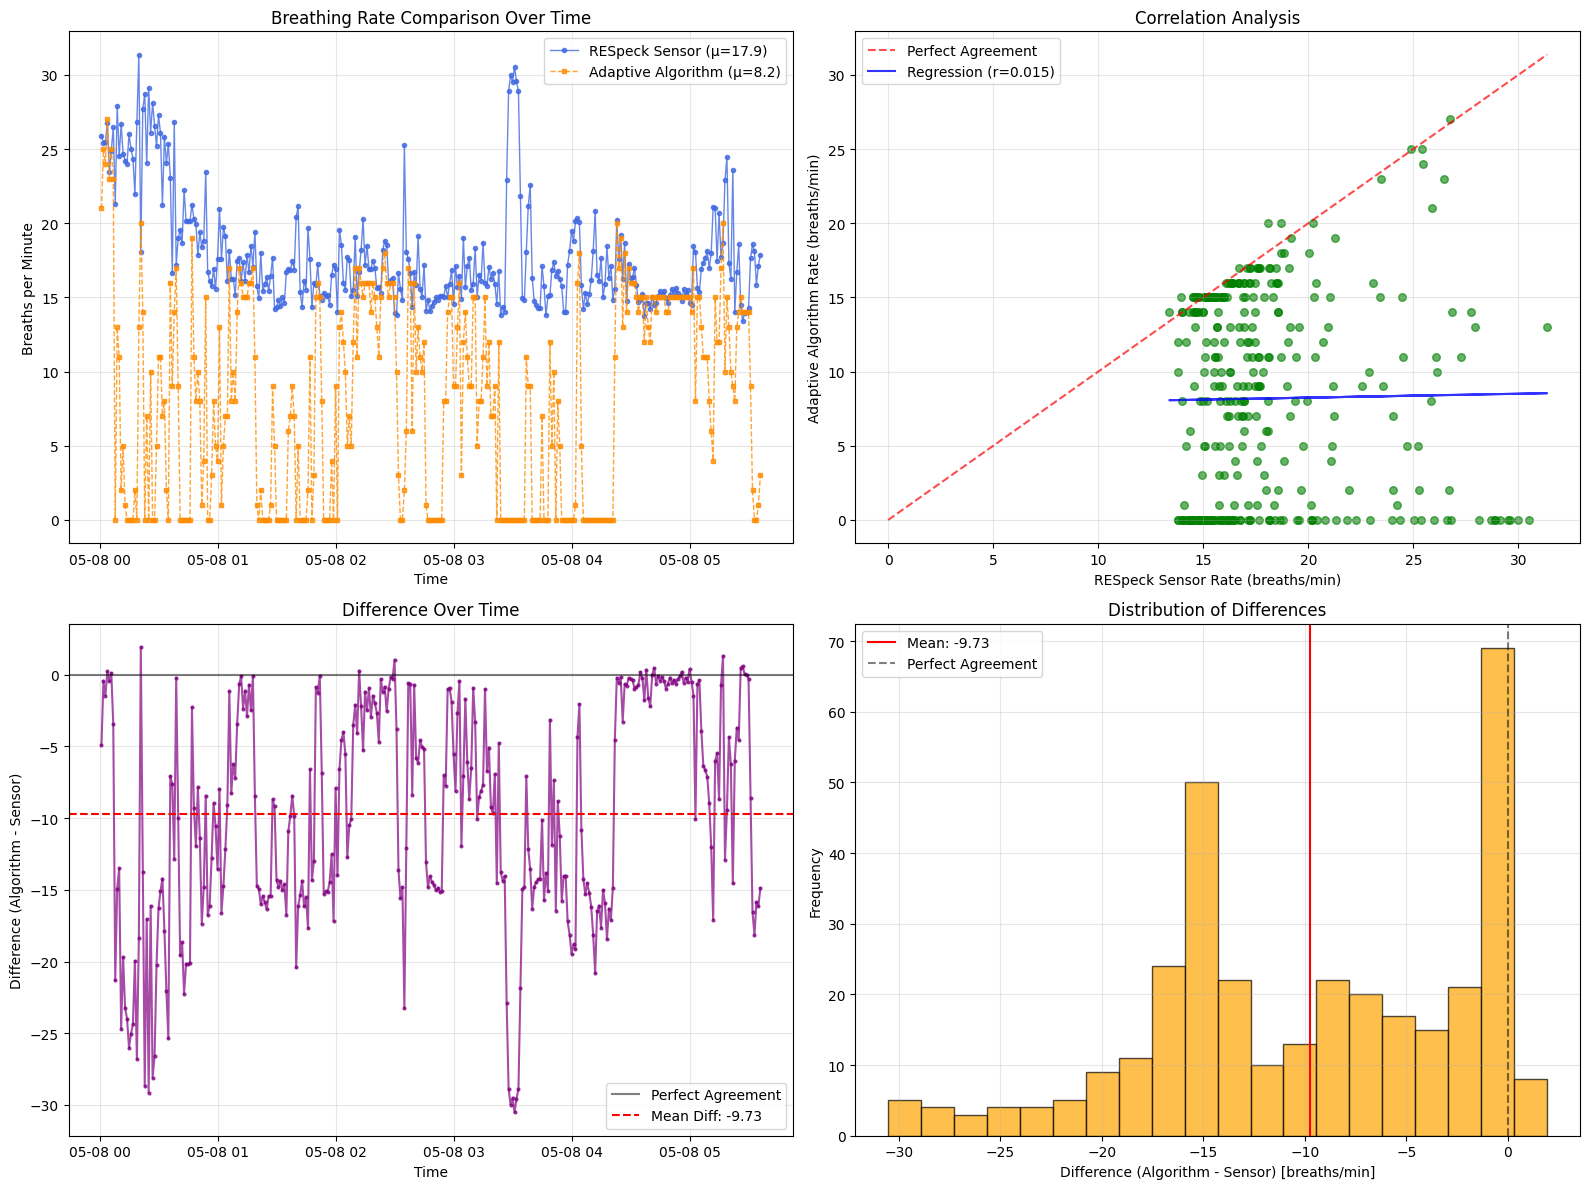

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

def compare_breathing_rates_over_time_corrected(df, window='1min', debug=False):
    """
    Corrected version that properly compares RESpeck sensor breathing rates
    with adaptive algorithm breathing rates over time.
    
    Key corrections:
    1. Counts full breathing cycles (not just inhalations)
    2. Proper timezone handling
    3. Better resampling strategy
    4. More robust comparison metrics
    """
    
    print("CORRECTED BREATHING RATE COMPARISON OVER TIME")
    print("=" * 50)
    
    # --- 1. Process RESpeck Sensor Data ---
    print("📊 Processing RESpeck sensor data...")
    
    respeck_sensor_data = df[['timestamp', 'breathingRate']].copy()
    respeck_sensor_data['breathingRate'] = pd.to_numeric(respeck_sensor_data['breathingRate'], errors='coerce')
    
    # Only keep valid breathing rate measurements
    valid_respeck = respeck_sensor_data.dropna(subset=['breathingRate'])
    
    if valid_respeck.empty:
        print("❌ No valid RESpeck breathing rate data available")
        return None
    
    print(f"✅ Found {len(valid_respeck):,} valid RESpeck measurements")
    print(f"   Time range: {valid_respeck['timestamp'].min()} to {valid_respeck['timestamp'].max()}")
    print(f"   Rate range: {valid_respeck['breathingRate'].min():.1f} - {valid_respeck['breathingRate'].max():.1f} breaths/min")
    
    # Create time series - NO forward fill to avoid propagating stale data
    respeck_rate_series = valid_respeck.set_index('timestamp')['breathingRate'].resample(window).mean()
    
    # --- 2. Process Adaptive Algorithm Data ---
    print("\n🤖 Running adaptive algorithm...")
    
    # Use your existing function name (assuming it's available)
    try:
        breath_df, stats = getBreathsConservative(df, return_dataframe=True)
    except NameError:
        print("❌ adaptive_breath_detection function not found. Please make sure it's defined.")
        return None
    
    breath_df['timestamp'] = breath_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bishkek')

    if breath_df.empty:
        print("❌ Adaptive algorithm detected no breaths")
        return None
    
    print(f"✅ Algorithm detected {len(breath_df):,} breath events")
    print(f"   {stats['inhalations']} inhalations, {stats['exhalations']} exhalations")
    print(f"   Overall rate: {stats['breaths_per_minute']:.1f} breaths/min")
    
    # --- 3. CRITICAL FIX: Count breathing cycles, not just inhalations ---
    breath_df_copy = breath_df.copy()
    
    # Ensure timezone compatibility
    if hasattr(valid_respeck['timestamp'].dtype, 'tz') and valid_respeck['timestamp'].dtype.tz is not None:
        # RESpeck has timezone, ensure breath_df matches
        if not (hasattr(breath_df_copy['timestamp'].dtype, 'tz') and breath_df_copy['timestamp'].dtype.tz is not None):
            breath_df_copy['timestamp'] = breath_df_copy['timestamp'].dt.tz_localize(valid_respeck['timestamp'].dtype.tz)
            if debug:
                print("🔧 Aligned algorithm timestamps with RESpeck timezone")
    else:
        # RESpeck is timezone-naive, ensure breath_df is too
        if hasattr(breath_df_copy['timestamp'].dtype, 'tz') and breath_df_copy['timestamp'].dtype.tz is not None:
            breath_df_copy['timestamp'] = breath_df_copy['timestamp'].dt.tz_localize(None)
            if debug:
                print("🔧 Converted algorithm timestamps to timezone-naive")
    
    # Calculate breathing cycles per minute (proper method)
    breath_df_indexed = breath_df_copy.set_index('timestamp')
    
    # Resample and count both inhalations and exhalations
    inhalations_per_min = breath_df_indexed[breath_df_indexed['type'] == 'Inhalation'].resample(window).size()
    exhalations_per_min = breath_df_indexed[breath_df_indexed['type'] == 'Exhalation'].resample(window).size()
    
    # Breathing rate = minimum of inhalations and exhalations (complete cycles)
    algo_rate_series = pd.DataFrame({'inhalations': inhalations_per_min, 'exhalations': exhalations_per_min}).min(axis=1)
    
    if debug:
        print(f"   Algorithm time range: {breath_df_copy['timestamp'].min()} to {breath_df_copy['timestamp'].max()}")
    
    # --- 4. Combine Data for Comparison ---
    print(f"\n🔗 Combining data for comparison...")
    
    # Find overlapping time period
    respeck_start = respeck_rate_series.index.min()
    respeck_end = respeck_rate_series.index.max()
    algo_start = algo_rate_series.index.min()
    algo_end = algo_rate_series.index.max()
    
    overlap_start = max(respeck_start, algo_start)
    overlap_end = min(respeck_end, algo_end)
    
    print(f"   RESpeck data: {respeck_start} to {respeck_end}")
    print(f"   Algorithm data: {algo_start} to {algo_end}")
    print(f"   Overlap period: {overlap_start} to {overlap_end}")
    
    if overlap_start >= overlap_end:
        print("❌ No temporal overlap between datasets!")
        return None
    
    # Create comparison DataFrame for overlap period only
    comparison_df = pd.DataFrame({
        'respeck_sensor_rate': respeck_rate_series,
        'adaptive_algo_rate': algo_rate_series
    })
    
    # Filter to overlap period and remove NaN values
    comparison_df = comparison_df.loc[overlap_start:overlap_end].dropna()
    
    if comparison_df.empty:
        print("❌ No valid comparison points in overlap period")
        return None
    
    print(f"✅ Found {len(comparison_df):,} valid comparison points")
    
    # --- 5. Statistical Analysis ---
    print(f"\n📈 STATISTICAL ANALYSIS:")
    
    respeck_values = comparison_df['respeck_sensor_rate'].values
    adaptive_values = comparison_df['adaptive_algo_rate'].values
    
    # Basic statistics
    respeck_mean = np.mean(respeck_values)
    adaptive_mean = np.mean(adaptive_values)
    respeck_std = np.std(respeck_values)
    adaptive_std = np.std(adaptive_values)
    
    # Comparison metrics
    difference = adaptive_mean - respeck_mean
    percent_diff = (difference / respeck_mean) * 100 if respeck_mean != 0 else float('inf')
    mae = np.mean(np.abs(adaptive_values - respeck_values))
    rmse = np.sqrt(np.mean((adaptive_values - respeck_values)**2))
    
    # Correlation
    if len(respeck_values) > 1 and len(adaptive_values) > 1:
        correlation, p_value = pearsonr(respeck_values, adaptive_values)
    else:
        correlation, p_value = 0, 1
    
    # Clinical agreement
    within_2_bpm = np.sum(np.abs(adaptive_values - respeck_values) <= 2) / len(adaptive_values) * 100
    within_3_bpm = np.sum(np.abs(adaptive_values - respeck_values) <= 3) / len(adaptive_values) * 100
    
    print(f"RESpeck sensor (mean ± std): {respeck_mean:.1f} ± {respeck_std:.1f} breaths/min")
    print(f"Adaptive algorithm (mean ± std): {adaptive_mean:.1f} ± {adaptive_std:.1f} breaths/min")
    print(f"")
    print(f"Mean difference: {difference:+.1f} breaths/min ({percent_diff:+.1f}%)")
    print(f"Mean Absolute Error: {mae:.2f} breaths/min")
    print(f"Root Mean Square Error: {rmse:.2f} breaths/min")
    print(f"Correlation: {correlation:.3f} (p={p_value:.3f})")
    print(f"")
    print(f"Clinical Agreement:")
    print(f"  Within ±2 breaths/min: {within_2_bpm:.1f}%")
    print(f"  Within ±3 breaths/min: {within_3_bpm:.1f}%")
    
    # Overall assessment
    print(f"\n🎯 OVERALL ASSESSMENT:")
    if abs(difference) < 1 and correlation > 0.7:
        print("✅ Excellent agreement!")
    elif abs(difference) < 2 and correlation > 0.5:
        print("🟡 Good agreement")
    elif abs(difference) < 4 and correlation > 0.3:
        print("🟠 Moderate agreement")
    else:
        print("❌ Poor agreement - needs investigation")
    
    # --- 6. Visualizations ---
    create_comparison_plots(comparison_df, correlation, respeck_mean, adaptive_mean)
    
    # --- 7. Return Results ---
    results = {
        'comparison_df': comparison_df,
        'respeck_mean': respeck_mean,
        'adaptive_mean': adaptive_mean,
        'difference': difference,
        'percent_difference': percent_diff,
        'correlation': correlation,
        'p_value': p_value,
        'mae': mae,
        'rmse': rmse,
        'within_2_bpm': within_2_bpm,
        'within_3_bmp': within_3_bpm,
        'comparison_points': len(comparison_df),
        'overlap_duration': overlap_end - overlap_start
    }
    
    return results

def create_comparison_plots(comparison_df, correlation, respeck_mean, adaptive_mean):
    """
    Create comprehensive comparison plots
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Time series comparison
    ax1 = axes[0, 0]
    ax1.plot(comparison_df.index, comparison_df['respeck_sensor_rate'], 
             label=f'RESpeck Sensor (μ={respeck_mean:.1f})', 
             color='royalblue', alpha=0.8, marker='o', markersize=3, linewidth=1)
    ax1.plot(comparison_df.index, comparison_df['adaptive_algo_rate'], 
             label=f'Adaptive Algorithm (μ={adaptive_mean:.1f})', 
             color='darkorange', alpha=0.8, marker='s', markersize=3, linewidth=1, linestyle='--')
    
    ax1.set_title('Breathing Rate Comparison Over Time')
    ax1.set_ylabel('Breaths per Minute')
    ax1.set_xlabel('Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Scatter plot with correlation
    ax2 = axes[0, 1]
    ax2.scatter(comparison_df['respeck_sensor_rate'], comparison_df['adaptive_algo_rate'], 
               alpha=0.6, s=30, color='green')
    
    # Perfect agreement line
    min_val = min(comparison_df['respeck_sensor_rate'].min(), comparison_df['adaptive_algo_rate'].min())
    max_val = max(comparison_df['respeck_sensor_rate'].max(), comparison_df['adaptive_algo_rate'].max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect Agreement')
    
    # Regression line
    z = np.polyfit(comparison_df['respeck_sensor_rate'], comparison_df['adaptive_algo_rate'], 1)
    p = np.poly1d(z)
    ax2.plot(comparison_df['respeck_sensor_rate'], p(comparison_df['respeck_sensor_rate']), 
             color='blue', alpha=0.8, label=f'Regression (r={correlation:.3f})')
    
    ax2.set_xlabel('RESpeck Sensor Rate (breaths/min)')
    ax2.set_ylabel('Adaptive Algorithm Rate (breaths/min)')
    ax2.set_title('Correlation Analysis')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Difference over time (Bland-Altman style)
    ax3 = axes[1, 0]
    differences = comparison_df['adaptive_algo_rate'] - comparison_df['respeck_sensor_rate']
    ax3.plot(comparison_df.index, differences, color='purple', alpha=0.7, marker='o', markersize=2)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='Perfect Agreement')
    ax3.axhline(y=differences.mean(), color='red', linestyle='--', 
               label=f'Mean Diff: {differences.mean():.2f}')
    
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Difference (Algorithm - Sensor)')
    ax3.set_title('Difference Over Time')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Distribution of differences
    ax4 = axes[1, 1]
    ax4.hist(differences, bins=20, alpha=0.7, edgecolor='black', color='orange')
    ax4.axvline(x=differences.mean(), color='red', linestyle='-', 
               label=f'Mean: {differences.mean():.2f}')
    ax4.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Perfect Agreement')
    
    ax4.set_xlabel('Difference (Algorithm - Sensor) [breaths/min]')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Distribution of Differences')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
# # Run the corrected comparison
results = compare_breathing_rates_over_time_corrected(respeck_df, window='1min', debug=True)